# ARIMA Forecasting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import statsmodels.api as sm
from pylab import rcParams
from datetime import datetime
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot

rcParams['figure.figsize'] = 18, 10


A quick inspection at data reveal our data is the first day of every month for every year between 1992-2020. We forecast the Coal.SA series

## If using Colab

In [ ]:

# step 1- Mount your Google Drive to Collaboratory

#from google.colab import drive 
#drive.mount('/content/gdrive')
#df=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Big Data Analytics/coal-25082020.csv')

In [2]:
df = pd.read_csv("coal-25082020.csv")
df.Date = pd.to_datetime(df.Date, dayfirst=True)
df = df.sort_values(by='Date')
df = df.set_index('Date')
df.index=pd.to_datetime(df.index.strftime("%Y-%d-%m"))

# Data Cleaning

In [3]:
nan_values_array = []
for column in df:
     nan_values_array.append(df[column].isnull().sum())

In [4]:
column_names = list(df.columns.values)
data = {'Feature':column_names,'Number of NaN values':nan_values_array}
nan_values = pd.DataFrame(data)
print(nan_values)

                Feature  Number of NaN values
0        Coal.Australia                     0
1               Coal.SA                     0
2              CrudeOil                     0
3            Fuel.Index                     1
4            NaturalGas                     0
5   Coal.Producer.Index                     0
6                  Gold                     1
7                Silver                     0
8                Copper                     0
9               IronOre                     1
10       CrudeOil.Index                     0
11          Metal.Index                     0
12        NonFuel.Index                     0
13      Commodity.Index                     0
14                  CLI                     1
15                  CCI                     0
16                  BCI                     0


Our data looks pretty clean. We dealed with missing data using "Mean Imputation" method. We will fill the NaN values with the mean of the corresponding attributes. We need to deal with those NaN values even though they are not that much, because in feature selection steps some methods needs data to be NaN value free.

In [5]:
df['Fuel.Index'].fillna(value=df['Fuel.Index'].mean(),inplace=True)
df['Gold'].fillna(value=df['Gold'].mean(),inplace=True)
df['IronOre'].fillna(value=df['IronOre'].mean(),inplace=True)
df['CLI'].fillna(value=df['CLI'].mean(),inplace=True)
df.isnull().values.any()

False

# Feature Selection and Correlation


First we will analyze the correlation between features by correlation matrix and we will visualize it with heatmap. We will compare both Spearman and Pearson correlation coefficients.

### Pearson Correlation Coefficient

In [6]:
#Default of this method is 'Pearson'
df.corr()

Coal.Australia   Coal.SA  CrudeOil  Fuel.Index  \
Coal.Australia             1.000000  0.987597  0.850179    0.851378   
Coal.SA                    0.987597  1.000000  0.871322    0.873123   
CrudeOil                   0.850179  0.871322  1.000000    0.995256   
Fuel.Index                 0.851378  0.873123  0.995256    1.000000   
NaturalGas                 0.255521  0.290419  0.406549    0.466557   
Coal.Producer.Index        0.810126  0.823938  0.796077    0.774840   
Gold                       0.783050  0.801117  0.771491    0.743783   
Silver                     0.810518  0.829874  0.861501    0.838364   
Copper                     0.864974  0.874786  0.915172    0.905553   
IronOre                    0.852453  0.862946  0.904424    0.902277   
CrudeOil.Index             0.847381  0.870686  0.996619    0.990689   
Metal.Index                0.854603  0.865686  0.909210    0.908074   
NonFuel.Index              0.901460  0.910450  0.924016    0.913937   
Commodity.Index            0.887339  0.907782  0.987910    0.982795   
CLI                        0.082951  0.091018  0.172163    0.167970   
CCI                       -0.542247 -0.539615 -0.523912   -0.531671   
BCI                        0.177860  0.180988  0.200040    0.194572   

                     NaturalGas  Coal.Producer.Index      Gold    Silver  \
Coal.Australia         0.255521             0.810126  0.783050  0.810518   
Coal.SA                0.290419             0.823938  0.801117  0.829874   
CrudeOil               0.406549             0.796077  0.771491  0.861501   
Fuel.Index             0.466557             0.774840  0.743783  0.838364   
NaturalGas             1.000000             0.012193 -0.057628  0.062815   
Coal.Producer.Index    0.012193             1.000000  0.967557  0.879425   
Gold                  -0.057628             0.967557  1.000000  0.917025   
Silver                 0.062815             0.879425  0.917025  1.000000   
Copper                 0.271090             0.854071  0.850084  0.887863   
IronOre                0.358885             0.721125  0.735615  0.833503   
CrudeOil.Index         0.393989             0.819444  0.791567  0.862686   
Metal.Index            0.387791             0.767045  0.764590  0.836922   
NonFuel.Index          0.230196             0.866988  0.866443  0.922447   
Commodity.Index        0.362033             0.855626  0.836704  0.905437   
CLI                    0.179731             0.010621  0.044130  0.105823   
CCI                   -0.164417            -0.492948 -0.490846 -0.515595   
BCI                    0.146136             0.069715  0.075308  0.153023   

                       Copper   IronOre  CrudeOil.Index  Metal.Index  \
Coal.Australia       0.864974  0.852453        0.847381     0.854603   
Coal.SA              0.874786  0.862946        0.870686     0.865686   
CrudeOil             0.915172  0.904424        0.996619     0.909210   
Fuel.Index           0.905553  0.902277        0.990689     0.908074   
NaturalGas           0.271090  0.358885        0.393989     0.387791   
Coal.Producer.Index  0.854071  0.721125        0.819444     0.767045   
Gold                 0.850084  0.735615        0.791567     0.764590   
Silver               0.887863  0.833503        0.862686     0.836922   
Copper               1.000000  0.886565        0.916779     0.980363   
IronOre              0.886565  1.000000        0.889031     0.914708   
CrudeOil.Index       0.916779  0.889031        1.000000     0.904568   
Metal.Index          0.980363  0.914708        0.904568     1.000000   
NonFuel.Index        0.964621  0.916057        0.916127     0.944256   
Commodity.Index      0.950226  0.918652        0.986068     0.936344   
CLI                  0.282215  0.166951        0.181964     0.339946   
CCI                 -0.458691 -0.583230       -0.496111    -0.430284   
BCI                  0.274979  0.123521        0.212045     0.305553   

                     NonFuel.Index  Commodity.Index       CLI       CCI  \
C

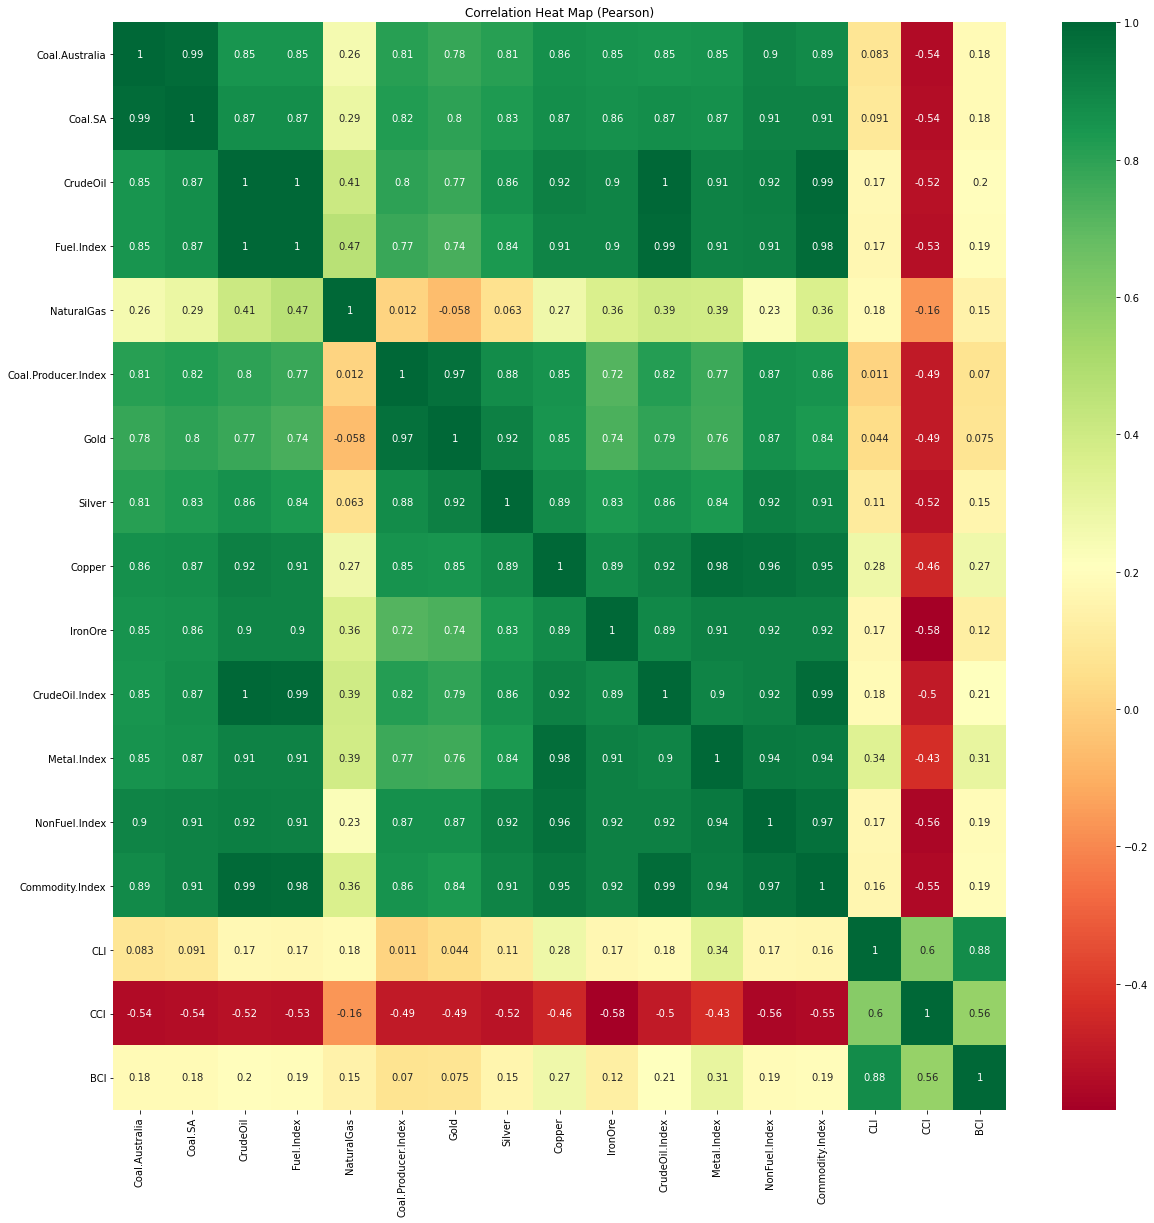

In [9]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn").set_title("Correlation Heat Map (Pearson)")

### Spearman Correlation Coefficient

In [10]:
df.corr(method='spearman')

Coal.Australia   Coal.SA  CrudeOil  Fuel.Index  \
Coal.Australia             1.000000  0.973604  0.825700    0.820585   
Coal.SA                    0.973604  1.000000  0.855360    0.850857   
CrudeOil                   0.825700  0.855360  1.000000    0.992517   
Fuel.Index                 0.820585  0.850857  0.992517    1.000000   
NaturalGas                 0.292782  0.366861  0.585672    0.623822   
Coal.Producer.Index        0.852715  0.858414  0.835841    0.820430   
Gold                       0.867391  0.867964  0.783084    0.767719   
Silver                     0.849249  0.857961  0.826411    0.813453   
Copper                     0.908248  0.893044  0.879207    0.872256   
IronOre                    0.863539  0.865173  0.899158    0.894594   
CrudeOil.Index             0.824017  0.855584  0.997040    0.987847   
Metal.Index                0.886046  0.885854  0.897172    0.892057   
NonFuel.Index              0.917062  0.904266  0.851992    0.846298   
Commodity.Index            0.873373  0.905722  0.977501    0.972673   
CLI                        0.197288  0.195795  0.255747    0.253454   
CCI                       -0.477537 -0.466701 -0.480276   -0.484887   
BCI                        0.276444  0.286296  0.272766    0.269419   

                     NaturalGas  Coal.Producer.Index      Gold    Silver  \
Coal.Australia         0.292782             0.852715  0.867391  0.849249   
Coal.SA                0.366861             0.858414  0.867964  0.857961   
CrudeOil               0.585672             0.835841  0.783084  0.826411   
Fuel.Index             0.623822             0.820430  0.767719  0.813453   
NaturalGas             1.000000             0.233309  0.148604  0.258498   
Coal.Producer.Index    0.233309             1.000000  0.931889  0.861441   
Gold                   0.148604             0.931889  1.000000  0.918048   
Silver                 0.258498             0.861441  0.918048  1.000000   
Copper                 0.354649             0.834572  0.873463  0.872711   
IronOre                0.461426             0.837785  0.811249  0.825872   
CrudeOil.Index         0.566852             0.844469  0.783456  0.826732   
Metal.Index            0.449583             0.790692  0.826023  0.857810   
NonFuel.Index          0.288322             0.852627  0.899988  0.911157   
Commodity.Index        0.541609             0.853923  0.842226  0.872452   
CLI                    0.266691             0.093087  0.138960  0.275775   
CCI                   -0.137696            -0.540761 -0.528130 -0.411287   
BCI                    0.271374             0.184543  0.185918  0.284948   

                       Copper   IronOre  CrudeOil.Index  Metal.Index  \
Coal.Australia       0.908248  0.863539        0.824017     0.886046   
Coal.SA              0.893044  0.865173        0.855584     0.885854   
CrudeOil             0.879207  0.899158        0.997040     0.897172   
Fuel.Index           0.872256  0.894594        0.987847     0.892057   
NaturalGas           0.354649  0.461426        0.566852     0.449583   
Coal.Producer.Index  0.834572  0.837785        0.844469     0.790692   
Gold                 0.873463  0.811249        0.783456     0.826023   
Silver               0.872711  0.825872        0.826732     0.857810   
Copper               1.000000  0.877198        0.869944     0.978305   
IronOre              0.877198  1.000000        0.896075     0.888762   
CrudeOil.Index       0.869944  0.896075        1.000000     0.885910   
Metal.Index          0.978305  0.888762        0.885910     1.000000   
NonFuel.Index        0.958723  0.875642        0.842783     0.935736   
Commodity.Index      0.921424  0.903172        0.971780     0.934856   
CLI                  0.336280  0.166245        0.258012     0.413420   
CCI                 -0.465062 -0.558628       -0.466452    -0.382067   
BCI                  0.352826  0.168960        0.271480     0.413140   

                     NonFuel.Index  Commodity.Index       CLI       CCI  \
C

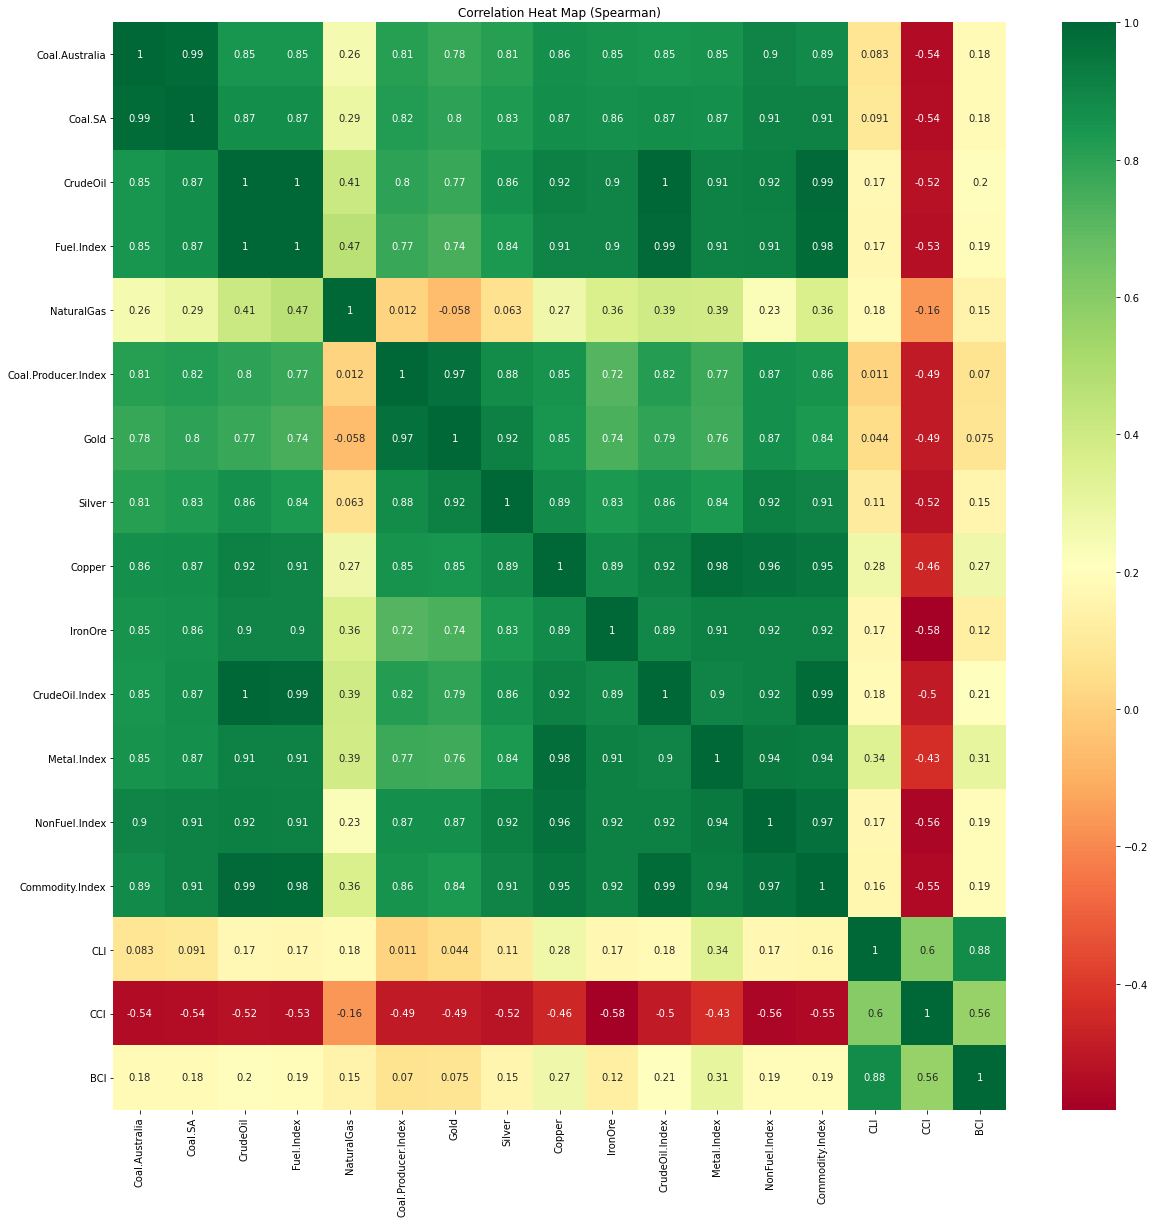

In [11]:
corrmat_spearman = df.corr(method='spearman')
top_corr_features = corrmat_spearman.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn").set_title("Correlation Heat Map (Spearman)")

As we can see, there is no big difference that needs to be considered between two different correlation coefficients. Therefore, we will continue with our feature selection step using Pearson Correlation Coefficient.

### Feature Selection

We will look at the features that have higher correlation than 0.5 with our target variable.

In [12]:
#Correlation with output variable
cor_target = abs(corrmat["Coal.SA"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

Coal.Australia         0.987597
Coal.SA                1.000000
CrudeOil               0.871322
Fuel.Index             0.873123
Coal.Producer.Index    0.823938
Gold                   0.801117
Silver                 0.829874
Copper                 0.874786
IronOre                0.862946
CrudeOil.Index         0.870686
Metal.Index            0.865686
NonFuel.Index          0.910450
Commodity.Index        0.907782
CCI                    0.539615
Name: Coal.SA, dtype: float64


Now, we will check the correlation between these variables. The reason why we need check the correlation between the attributes besides our target attribute, is to find the unnecessary ones. These unnecessary attributes will cause us problems such as overfitting during the machine learning step. Thus, we have to detect them and remove them from our data

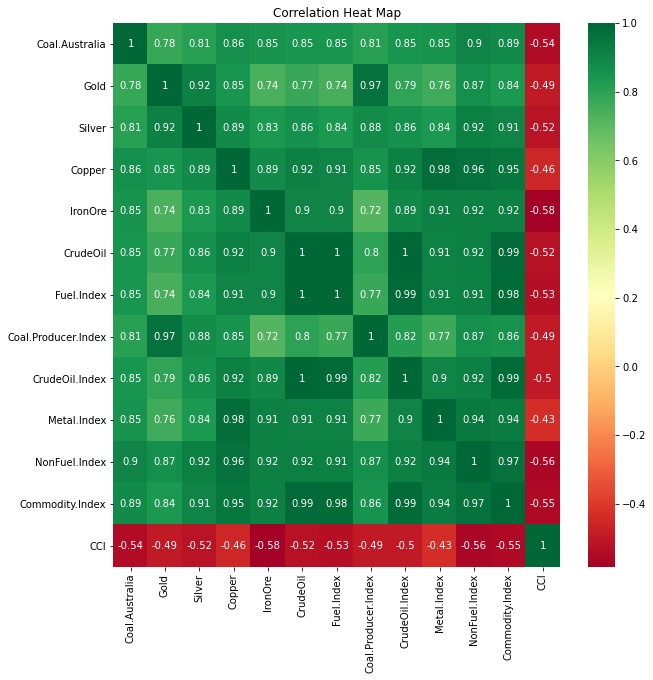

In [13]:
rf_df = df[['Coal.Australia', 'Gold','Silver','Copper','IronOre','CrudeOil','Fuel.Index','Coal.Producer.Index','CrudeOil.Index','Metal.Index','NonFuel.Index','Commodity.Index','CCI']]
fig, ax = plt.subplots(figsize=(10,10))
h=sns.heatmap(rf_df.corr(),annot=True,cmap="RdYlGn",ax=ax).set_title("Correlation Heat Map")

## Notes about correlation

From the above correlation matrix, we get the following results
    * Gold and Copper has high correlation
    * Gold and Coal.Producer.Index has high correlation
    * Silver and Gold has high Correlation
    * Silver and NonFuel.Index has high correlation also there is high correlation with Commodity.Index
    * Copper and CrudeOil,Fuel.Index,Metal.Index,NonFuel.Index,Commodity.Index and CrudeOil.Index has    high correlation
    * IronOre and Fuel.Index,CrudeOil,Metal.Index,NonFuel.Index,Commodity.Index has high correlation
    * CrudeOil and Metal.Index,NonFuel.Index,Commodity.Index has high correlation
    * CrudeOil.Index and Fuel.Index,NonFuel.Index,Metal.Index has high correlation
    * Metal.Index has high correlation with Fuel.Index,NonFuel.Index,Commodity.Index
    * NonFuel.Index has high correlation with Fuel.Index,Commodity.Index
    
 We will check these variables' correlation with our target variable and then drop the  attribute that has lowest correlation with our target. If two attribute has a high correlation between them, this means that they almost have linear relationship. So, we can think of them as a single variable basically. Therefore, we will see which one has the highest correlation with our target variable and remove the other one.

Text(0.5, 1.0, 'Metal.Index vs. Copper')

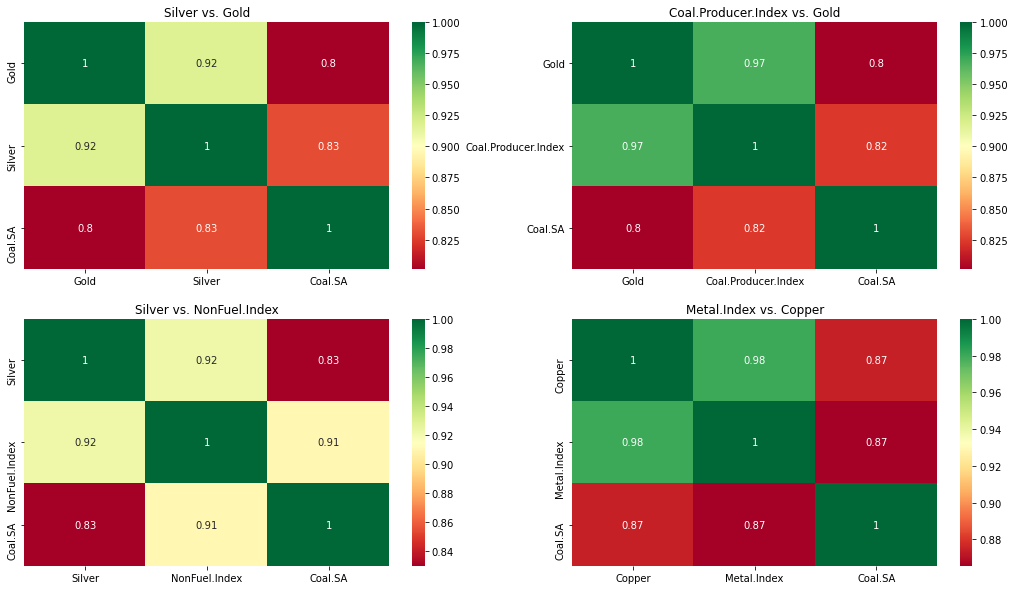

In [14]:
fig2,ax2 = plt.subplots(2,2)
sns.heatmap(df[['Gold','Silver','Coal.SA']].corr(),ax=ax2[0][0],annot=True,cmap="RdYlGn").set_title('Silver vs. Gold')
sns.heatmap(df[['Gold','Coal.Producer.Index','Coal.SA']].corr(),ax=ax2[0][1],annot=True,cmap="RdYlGn").set_title('Coal.Producer.Index vs. Gold')
sns.heatmap(df[['Silver','NonFuel.Index','Coal.SA']].corr(),ax=ax2[1][0],annot=True,cmap="RdYlGn").set_title('Silver vs. NonFuel.Index')
sns.heatmap(df[['Copper','Metal.Index','Coal.SA']].corr(),ax=ax2[1][1],annot=True,cmap="RdYlGn").set_title('Metal.Index vs. Copper')


We examined the attributes that has high correlation between them and observed their relationship with our target variable. After analysing the heatmaps above, we decided to drop "Gold, and Silver" attributes.

Text(0.5, 1.0, 'Fuel.Index vs. CrudeOil')

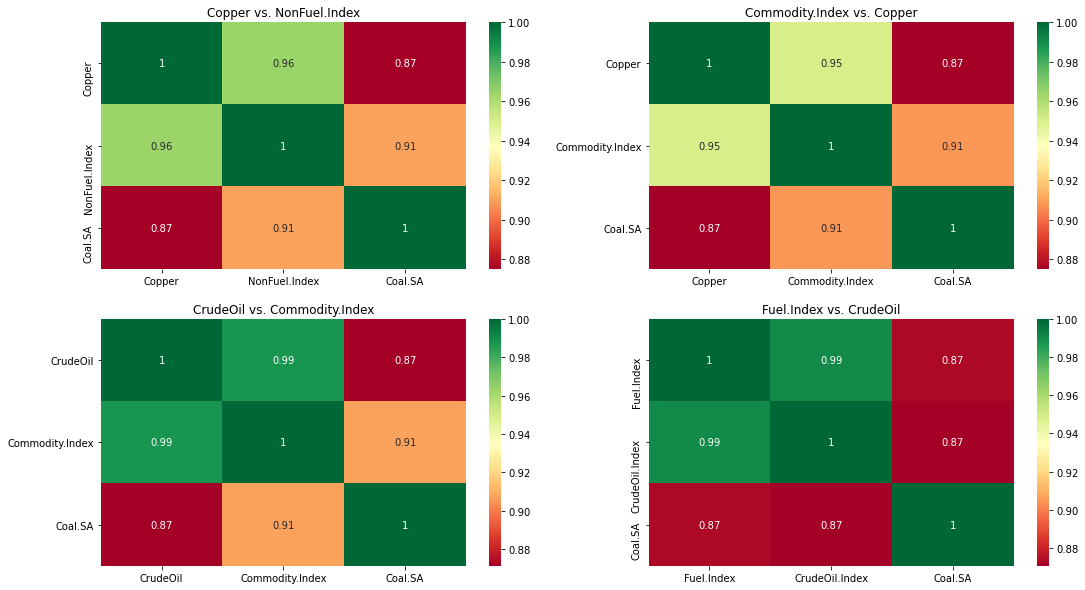

In [15]:
fig3,ax3 = plt.subplots(2,2)
sns.heatmap(df[['Copper','NonFuel.Index','Coal.SA']].corr(),ax=ax3[0][0],annot=True,cmap="RdYlGn").set_title('Copper vs. NonFuel.Index')
sns.heatmap(df[['Copper','Commodity.Index','Coal.SA']].corr(),ax=ax3[0][1],annot=True,cmap="RdYlGn").set_title('Commodity.Index vs. Copper')
sns.heatmap(df[['CrudeOil','Commodity.Index','Coal.SA']].corr(),ax=ax3[1][0],annot=True,cmap="RdYlGn").set_title('CrudeOil vs. Commodity.Index')
sns.heatmap(df[['Fuel.Index','CrudeOil.Index','Coal.SA']].corr(),ax=ax3[1][1],annot=True,cmap="RdYlGn").set_title('Fuel.Index vs. CrudeOil') 

After analysing the heatmaps above, we decided to drop "Gold, and Silver" attributes. We decide to take the attribute "Non-Fuel" and drop "Copper".

Text(0.5, 1.0, 'CrudeOil.Index vs. Commodity.Index')

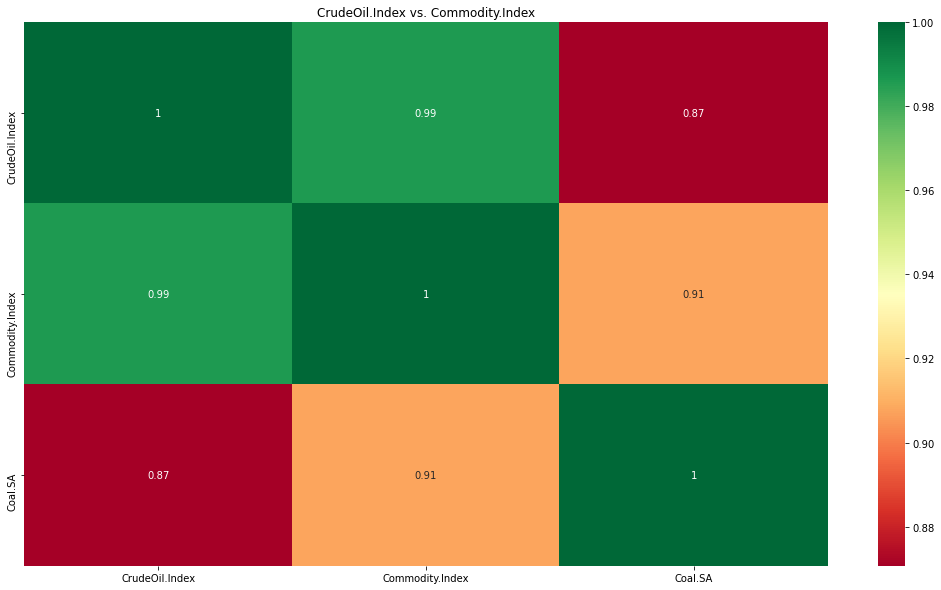

In [16]:
sns.heatmap(df[['CrudeOil.Index','Commodity.Index','Coal.SA']].corr(),annot=True,cmap="RdYlGn").set_title("CrudeOil.Index vs. Commodity.Index") 


We will take all the variables has high correlation with our target "Corel.SA" and drop the others with the ones we decide to eliminate after analysing the heatmaps above.


In [17]:
df.drop(['Gold','Silver','Copper','CrudeOil','CLI','BCI','NaturalGas'], axis=1,inplace=True)
df.head()
df.shape

(343, 10)

In [18]:
df.columns

Index(['Coal.Australia', 'Coal.SA', 'Fuel.Index', 'Coal.Producer.Index',
       'IronOre', 'CrudeOil.Index', 'Metal.Index', 'NonFuel.Index',
       'Commodity.Index', 'CCI'],
      dtype='object')

# Exploratory Data Analysis

Questions to be answered:

    1) Are there consistent patterns? 

    2) Is there a significant trend? 

    3) Is there seasonality?

    4) Is there evidence of the presence of cycles? 

    5) Are there any outliers in the data that need to be explained by those with expert knowledge? 

    6) How strong are the relationships among the variables available for analysis?


EDA: Plotting "trend". Visualize and check seasonality trend of our time series.



### Time Series Plot

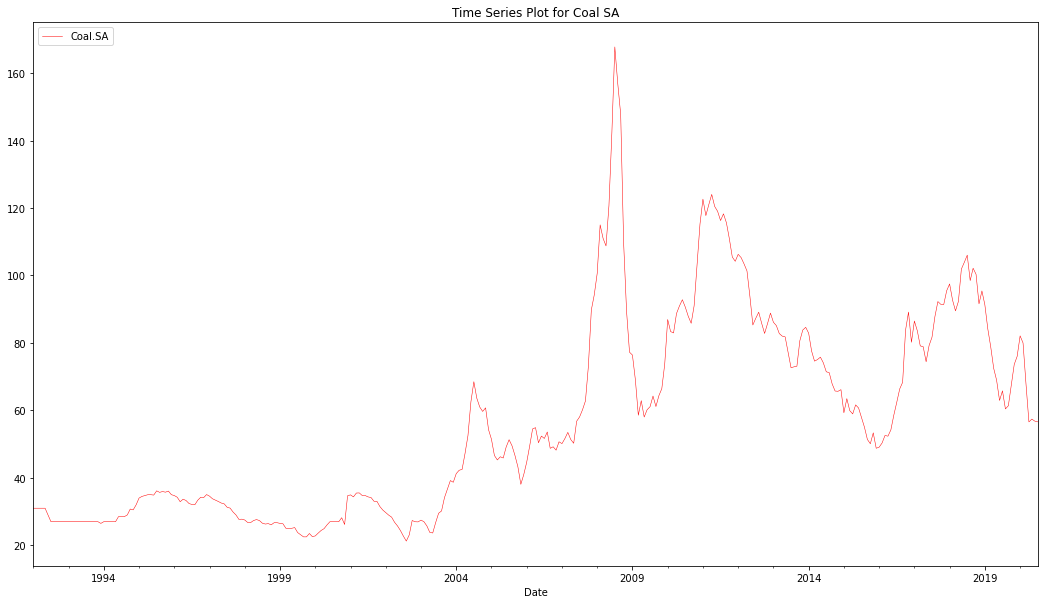

In [19]:
df["Coal.SA"].plot(linewidth=0.5, color='red')
plt.legend(df[["Coal.SA"]], loc ="upper left") 
plt.title("Time Series Plot for Coal SA")
plt.show()

Time series plot reveals that the coal prices have generally increased over time. There is a clear sign of trend. The variance seems to be low from 1992-2002 and is higher generally higher 2004 onwards. This indicates that in order to account for this increase in variance, we may need to take the log of the series. There are no cycles in the series. 
   

## Trend

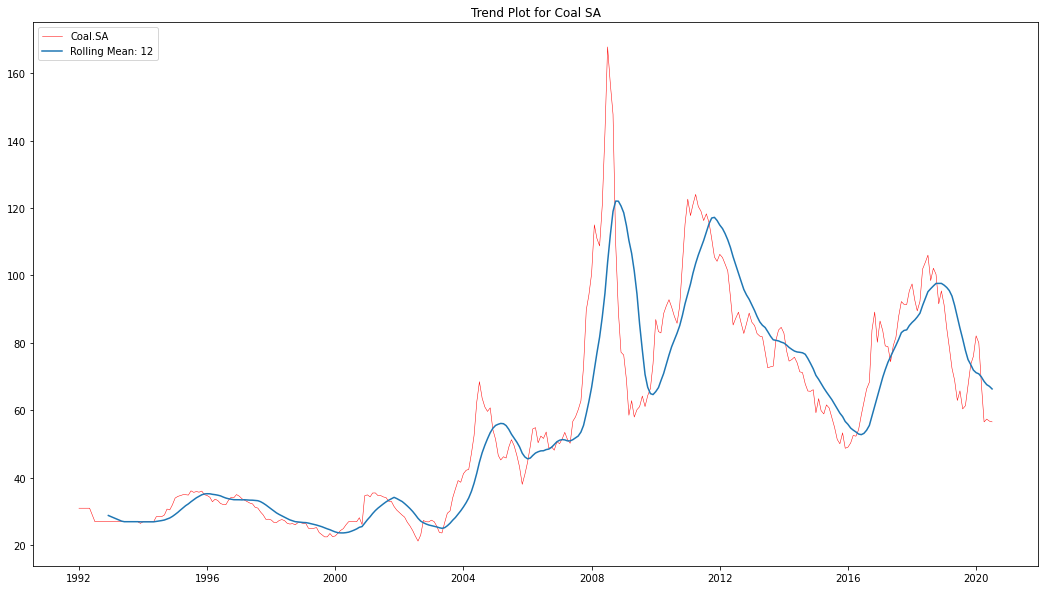

In [20]:
plt.plot(df.index, df["Coal.SA"], linewidth=0.5, color='red')
plt.plot(pd.Series.rolling(df["Coal.SA"], 12).mean())
plt.legend(["Coal.SA", "Rolling Mean: 12"], loc ="upper left") 
plt.title("Trend Plot for Coal SA")
plt.show()

The simple moving average is the unweighted mean of the previous M data points. Here M=12 to account for the annual effect.
We can see that:
1) Coal SA series has a trend. It goes up until around 2008 and then the trend changes direction and starting from 2008. Since there is trend, the time series is not stationary.

Because of the trend, we may say that the data is not stationary but such a hypothesis needs to be checked using the following methods: (ACF plot of the data as well as the Adjusted Dickey Fuller Test)

## Seasonality

In [21]:
df['Year'] = pd.DatetimeIndex(df.index).year
df['Month'] = pd.DatetimeIndex(df.index).month

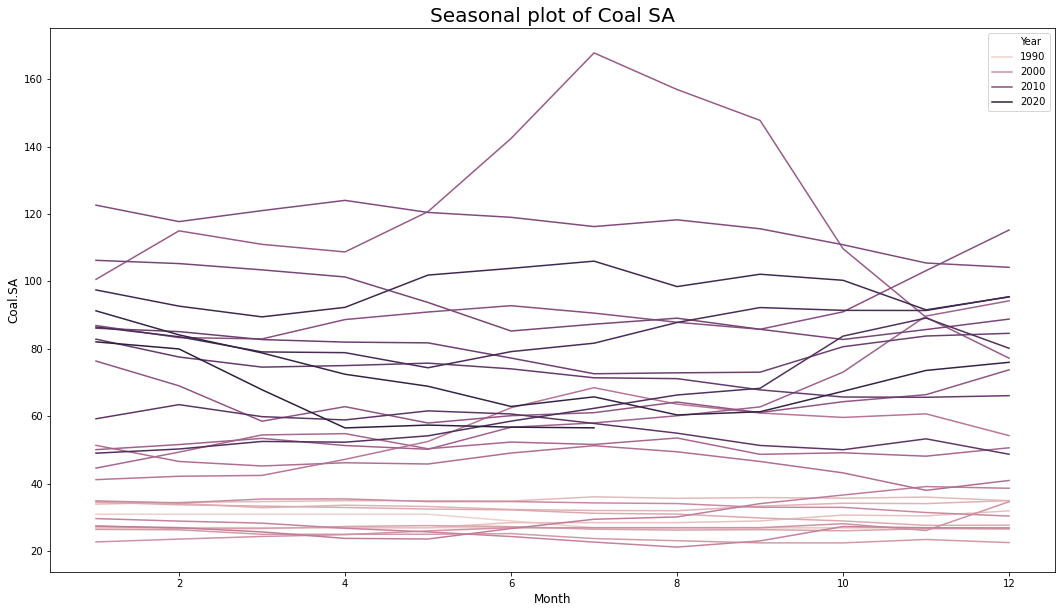

In [22]:
fig, ax = plt.subplots()
ax.set_xlabel('Month', fontsize = 12)
ax.set_ylabel('Seasonal Plot for Coal SA Price', fontsize = 12);
ax.set_title('Seasonal plot of Coal SA', fontsize = 20, loc='center');
sns.lineplot(x=df['Month'], y=df["Coal.SA"], hue=df['Year']);

Looking at the seasonal plot, there does not seem to be a significant increase or decrease from one month to another over the years, although in the obvious outlier, there seems to be an increase from April to July. However, the general picture reflects no "obvious" seasonality.

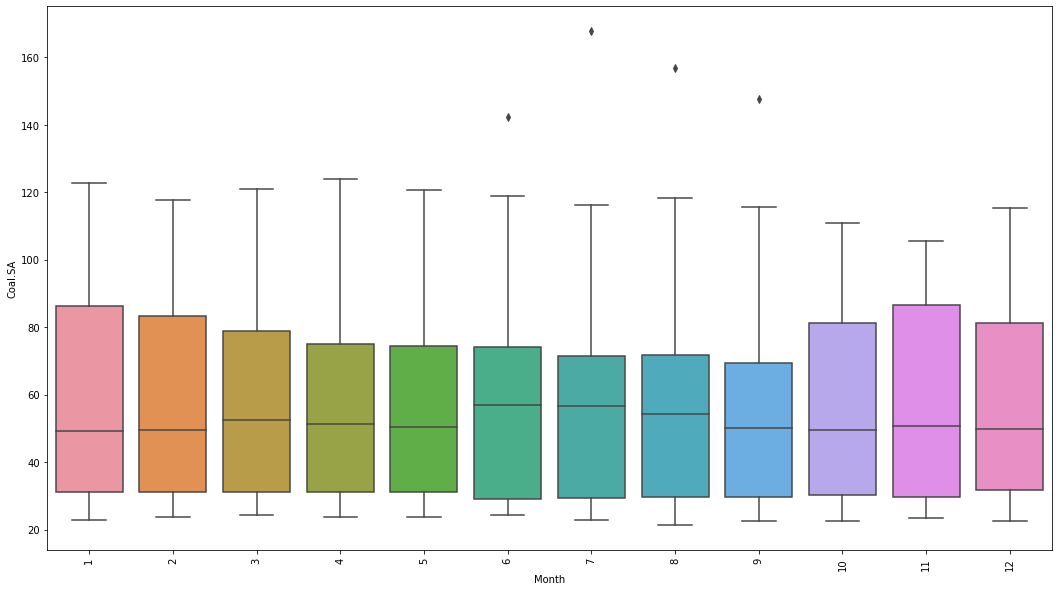

In [23]:
ax = sns.boxplot(data=df, x='Month', y='Coal.SA')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

As it can be seen from the seasonal boxplot, the overall level of all months are around the same, therefore we can again conclude there is no obvious seasonality. We also realize there are some outliers, looking back at the data for those levels, it indicates that the outliers are coming from the year 2008-2009.

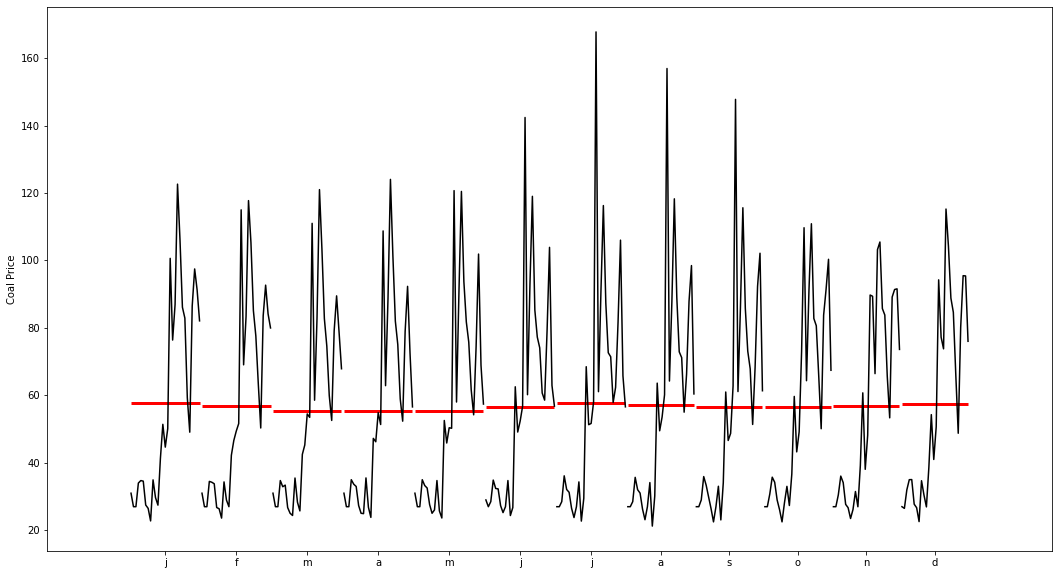

In [24]:
month_plot(df["Coal.SA"],ylabel='Coal Price');

As it can be seen from the seasonal subseries plot, the overall level of all months are around the same, therefore we can again conclude there is no obvious seasonality.

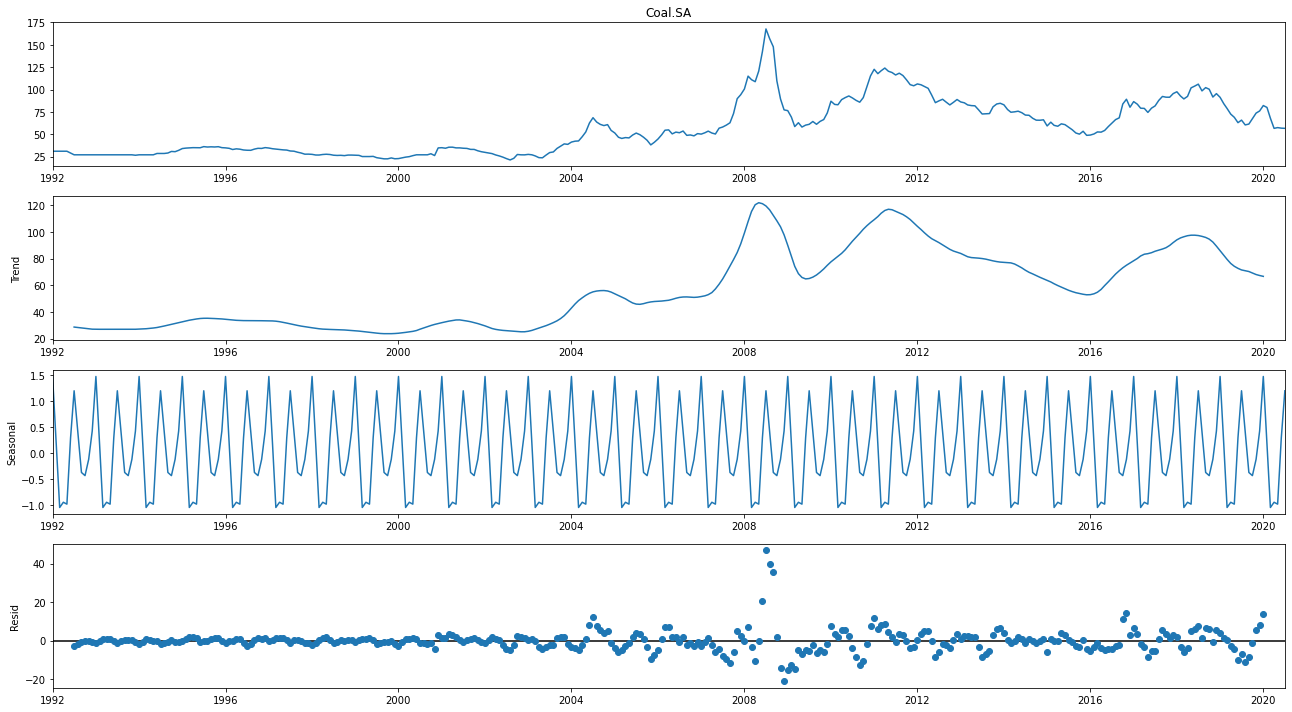

In [25]:
cls_decomposition = sm.tsa.seasonal_decompose(df["Coal.SA"], model='additive')
fig = cls_decomposition.plot()
plt.show()

From the classical decomposition, we can conclude that there appears to be no significant seasonality in the data since the seasonal component ranges from -1 to 1 (in the additive case does not have significant influence). We can see how little seasonality plays a role by plotting the seasonally adjusted and the original data together.

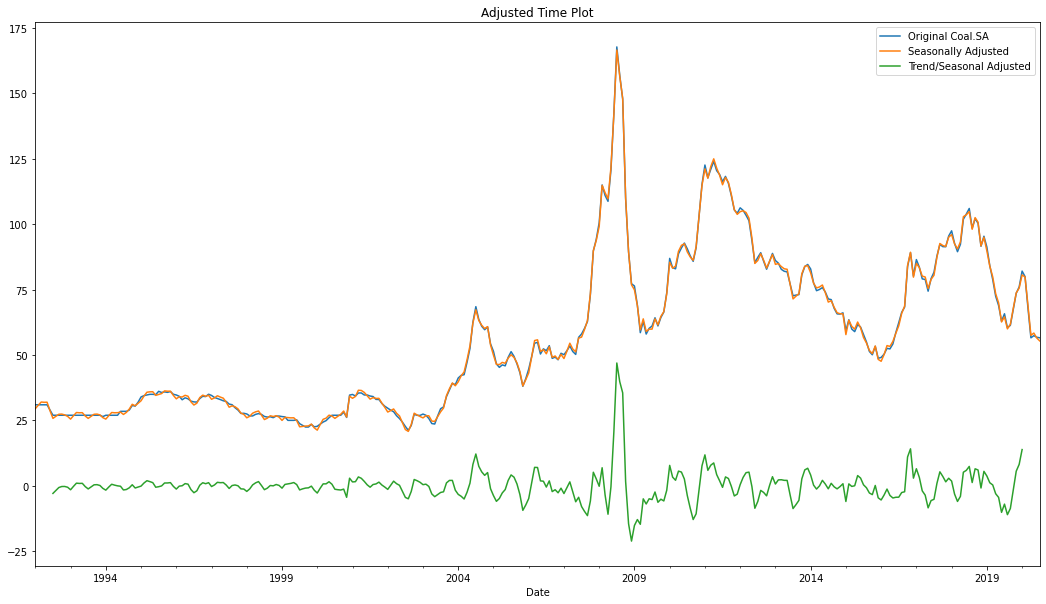

In [26]:
df["Coal.SA"].plot(label="Original Coal.SA")
df['Seasonally Adjusted'] = df['Coal.SA'] - cls_decomposition.seasonal
df["Seasonally Adjusted"].plot(label="Seasonally Adjusted")
df["Trend/Seasonal Adjusted"] = df["Coal.SA"] - cls_decomposition.seasonal- cls_decomposition.trend
df["Trend/Seasonal Adjusted"].plot(label="Trend/Seasonal Adjusted")
plt.legend();
plt.title("Adjusted Time Plot");

Here we can see that seasonality does not have a significant effect whereas the trend does.

## Handling Outliers


For every attribute we will check if there are any outliers by using box plots. We will examine the data both from years and months perspective. Since we do not have too much data, we will replace the outliers with the mean of the corresponding attribute.

### Checking Outliers (Month Perspective)


Text(0.5, 1.0, 'Coal.Producer.Index')

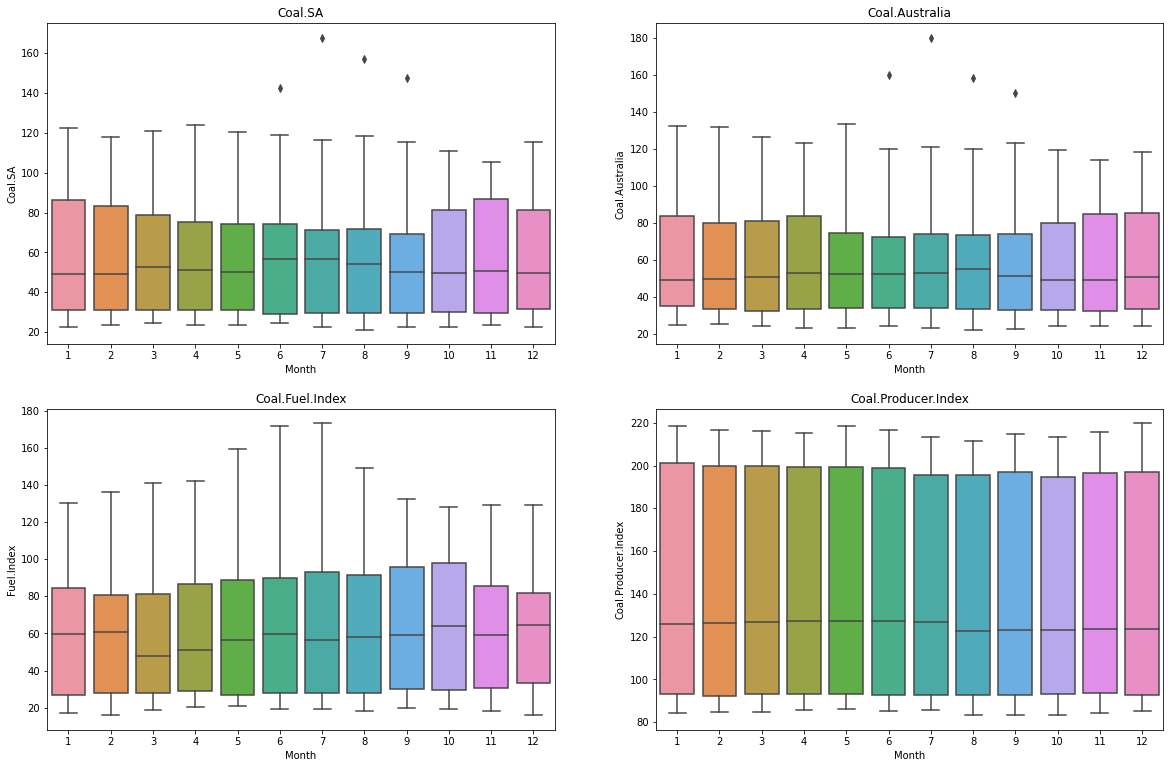

In [27]:
fig3,ax3 = plt.subplots(2,2,figsize=(20,13))
sns.boxplot(data=df, x='Month', y='Coal.SA',ax=ax3[0][0]).set_title("Coal.SA")
sns.boxplot(data=df, x='Month', y='Coal.Australia',ax=ax3[0][1]).set_title("Coal.Australia")
sns.boxplot(data=df, x='Month', y='Fuel.Index',ax=ax3[1][0]).set_title("Coal.Fuel.Index")
sns.boxplot(data=df, x='Month', y='Coal.Producer.Index',ax=ax3[1][1]).set_title("Coal.Producer.Index")

As we can see from the box-plots above we have outliers in our attributes Coal.SA and Coal.Australia.

Text(0.5, 1.0, 'Commodity.Index')

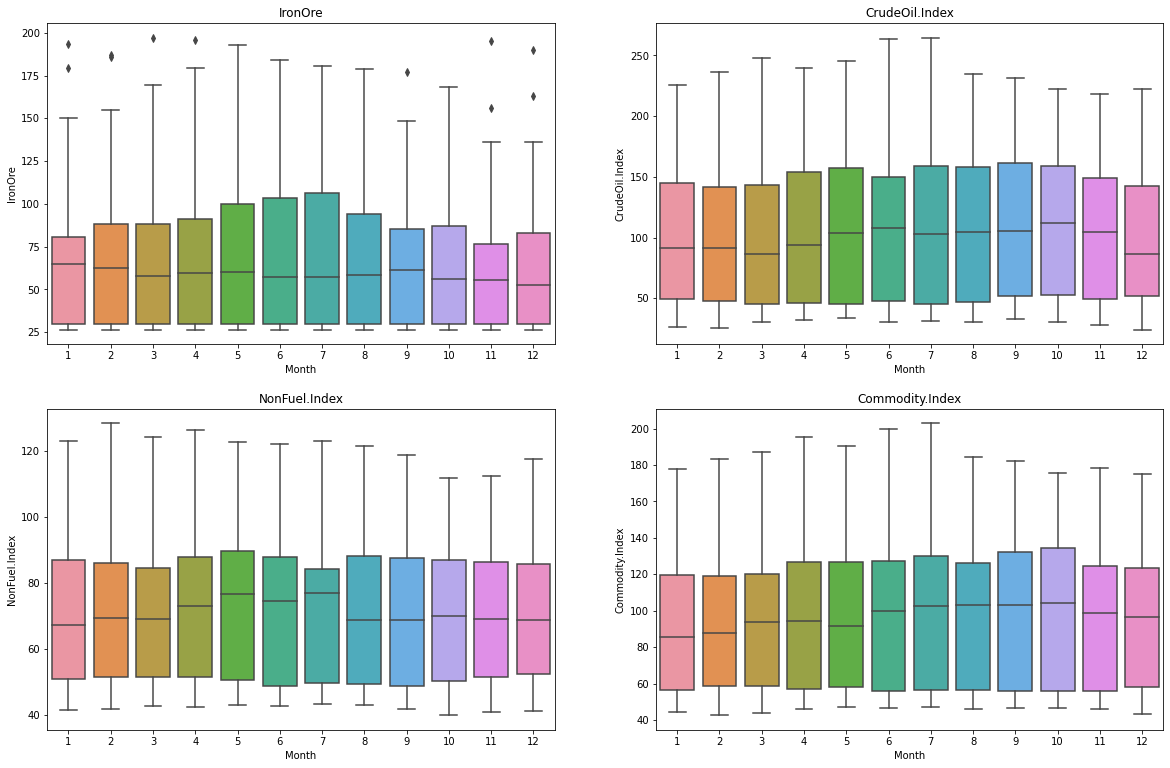

In [28]:
fig3,ax3 = plt.subplots(2,2,figsize=(20,13))
sns.boxplot(data=df, x='Month', y='IronOre',ax=ax3[0][0]).set_title("IronOre")
sns.boxplot(data=df, x='Month', y='CrudeOil.Index',ax=ax3[0][1]).set_title("CrudeOil.Index")
sns.boxplot(data=df, x='Month', y='NonFuel.Index',ax=ax3[1][0]).set_title("NonFuel.Index")
sns.boxplot(data=df, x='Month', y='Commodity.Index',ax=ax3[1][1]).set_title("Commodity.Index")

We can see that we have outliers in our attribute IronOre.

Text(0.5, 1.0, 'Metal.Index')

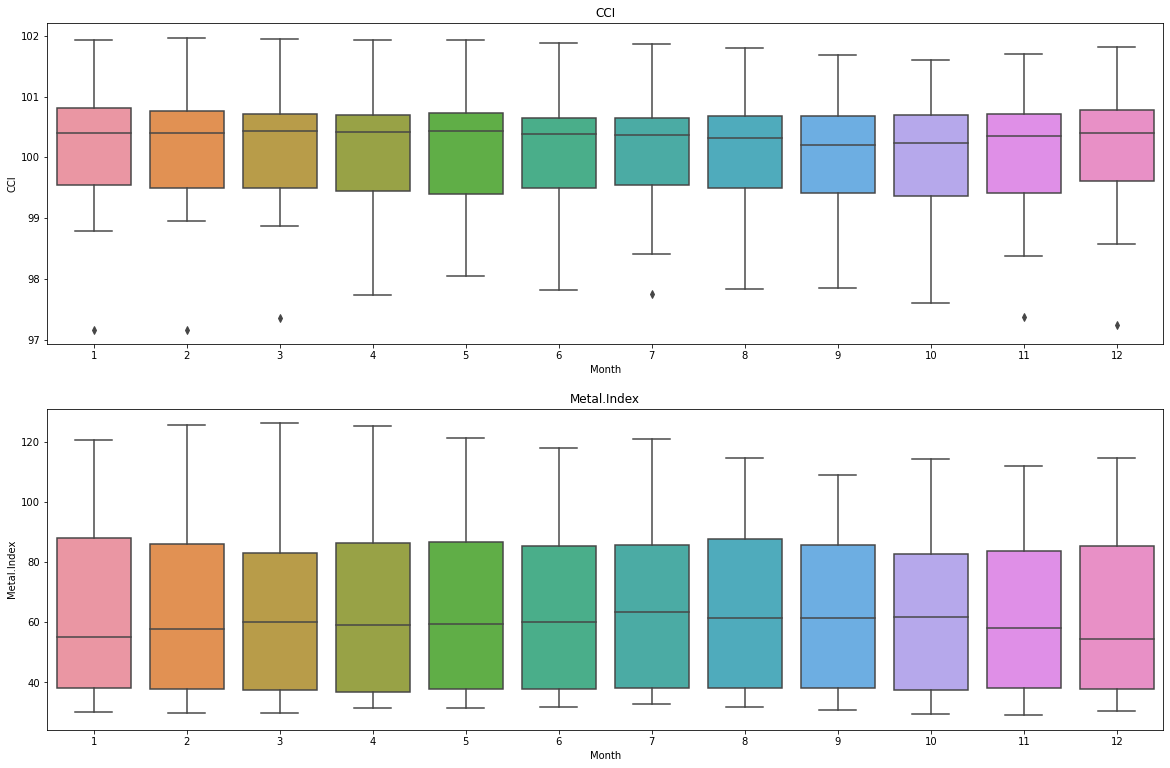

In [29]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Month',ax=ax3[0],y='CCI').set_title("CCI")
sns.boxplot(data=df, x='Month',ax=ax3[1],y='Metal.Index').set_title("Metal.Index")

Our attribute CCI also contains outliers.

### Replace the Outliers
As we can see, from month perspective,in some of the variables we have outliers. We will detect them using IQR score, and if they are below the lower whisker, we will assign lower_whisker + 1 to those values, and if they are above the upper whisker we will assign upper_whisker - 1. 

In [30]:
def calculate_whiskers(attribute,time,perspective):
    Q1=df.loc[df[perspective] == time, attribute].quantile(0.25)
    Q3=df.loc[df[perspective] == time, attribute].quantile(0.75)
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR
    Upper_Whisker = Q3 + 1.5*IQR
    return Upper_Whisker,Lower_Whisker

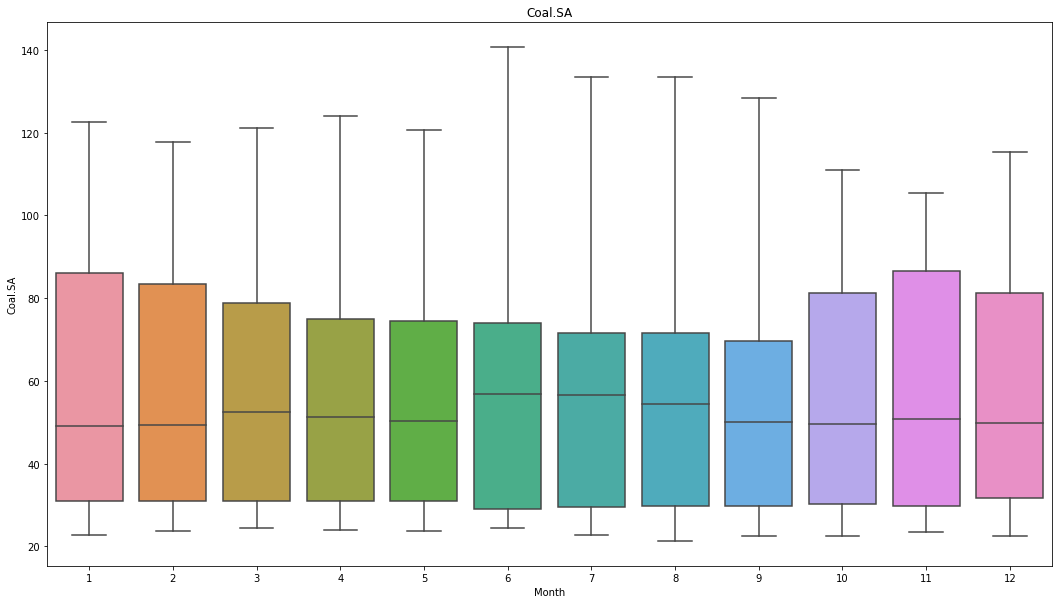

In [31]:
#For the target value "Coal.SA"
df.sort_values(by=['Coal.SA'],inplace=True)
months = [6,7,8,9]

for ind in df.index:
    for month in months:
        if (df['Month'][ind] == month): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.SA",month,"Month")
            if(df['Coal.SA'][ind] > Upper_Whisker):
                df.replace(df['Coal.SA'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.SA'][ind] < Lower_Whisker):
                df.replace(df['Coal.SA'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue      
ax = sns.boxplot(data=df, x='Month', y='Coal.SA').set_title("Coal.SA")

We successfully removed our attribute Coal.SA from the outliers!

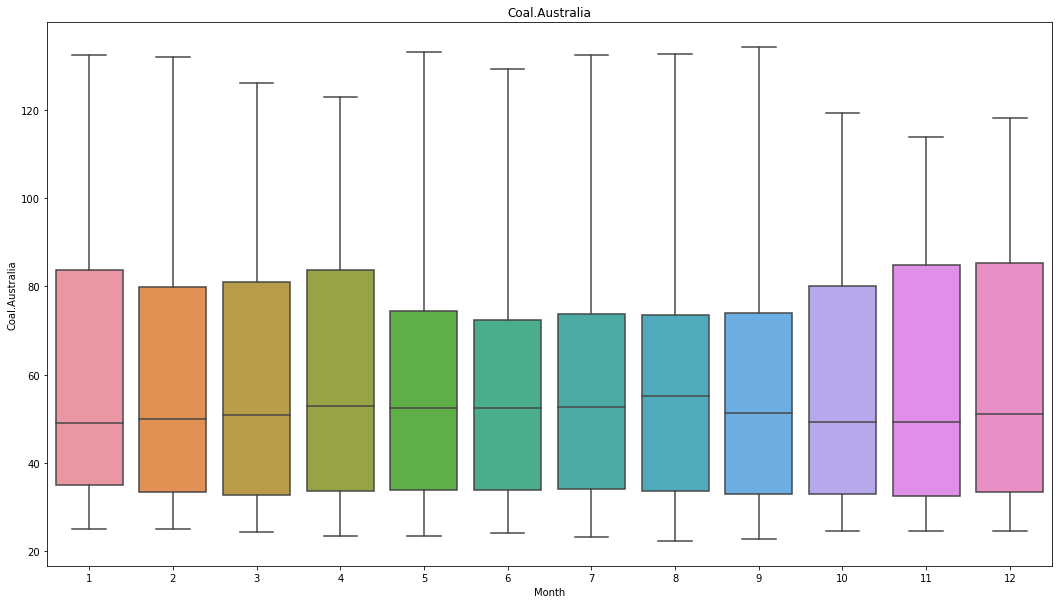

In [32]:
df.sort_values(by=['Coal.Australia'],inplace=True)

months = [6,7,8,9]

for ind in df.index:
    for month in months:
        if (df['Month'][ind] == month): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.Australia",month,"Month")
            if(df['Coal.Australia'][ind] > Upper_Whisker):
                df.replace(df['Coal.Australia'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.Australia'][ind] < Lower_Whisker):
                df.replace(df['Coal.Australia'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue  
                
ax = sns.boxplot(data=df, x='Month', y='Coal.Australia').set_title("Coal.Australia")

We successfully removed our attribute Coal.Australia from the outliers!

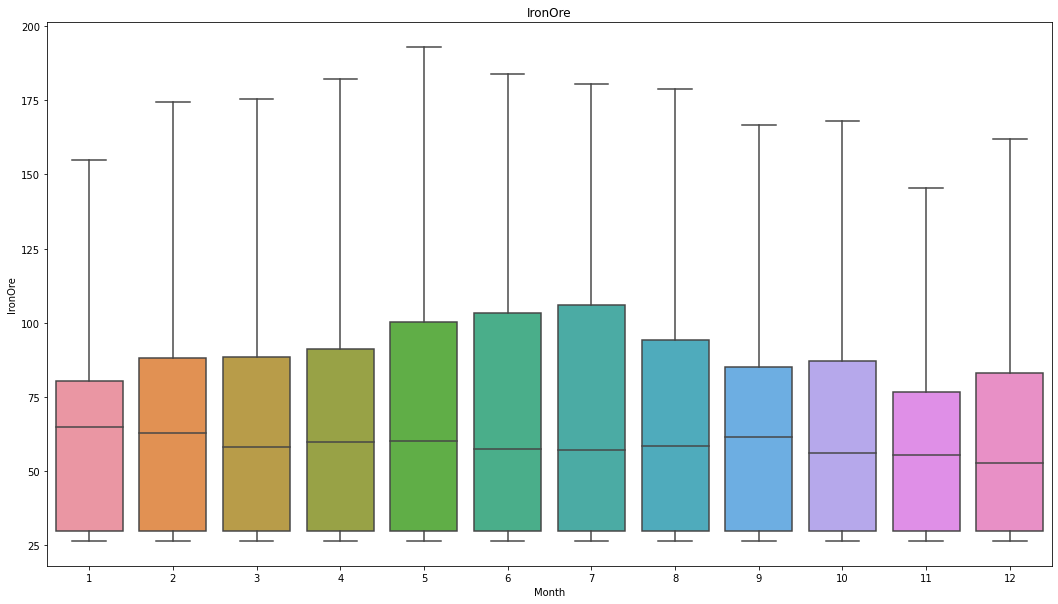

In [33]:
df.sort_values(by=['IronOre'],inplace=True)
months = [1,2,3,4,9,11,12]

for ind in df.index:
    for month in months:
        if (df['Month'][ind] == month): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("IronOre",month,"Month")
            if(df['IronOre'][ind] > Upper_Whisker):
                df.replace(df['IronOre'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['IronOre'][ind] < Lower_Whisker):
                df.replace(df['IronOre'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue  

ax = sns.boxplot(data=df, x='Month', y='IronOre').set_title("IronOre")

We successfully removed our attribute IronOre from the outliers!

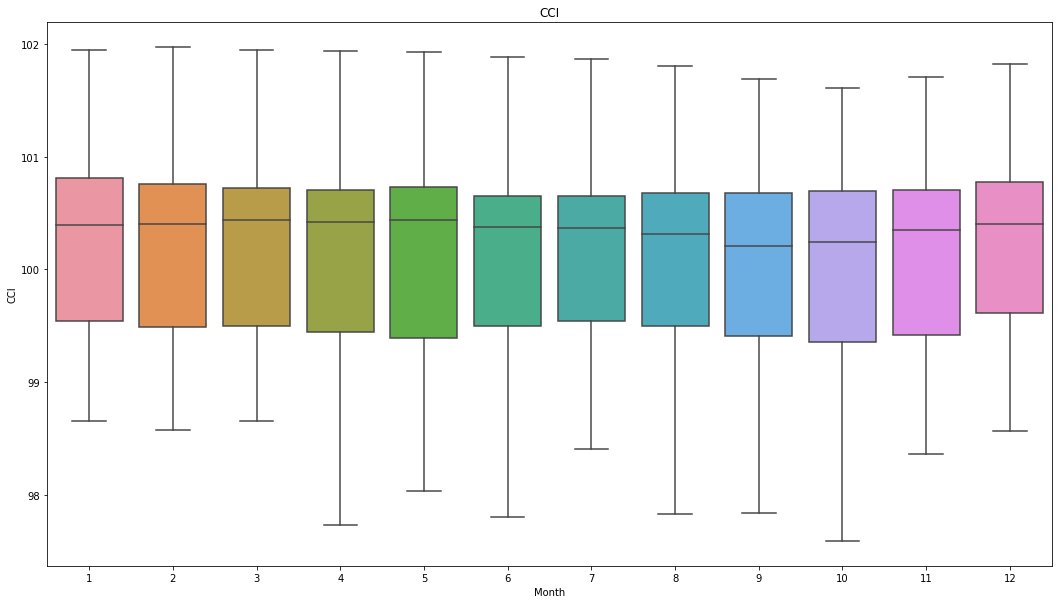

In [34]:
df.sort_values(by=['CCI'],inplace=True)

months = [1,2,3,7,11,12]

for ind in df.index:
    for month in months:
        if (df['Month'][ind] == month): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("CCI",month,"Month")
            if(df['CCI'][ind] > Upper_Whisker):
                df.replace(df['CCI'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['CCI'][ind] < Lower_Whisker):
                df.replace(df['CCI'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue  

ax = sns.boxplot(data=df, x='Month', y='CCI').set_title("CCI")            

As we can see, we removed the outliers.Our data looks outlier free!

In [ ]:
df.shape

## Checking Outliers (Year Perspective) 
Now we will look at the outliers from year perspective.

Text(0.5, 1.0, 'Coal.Australia')

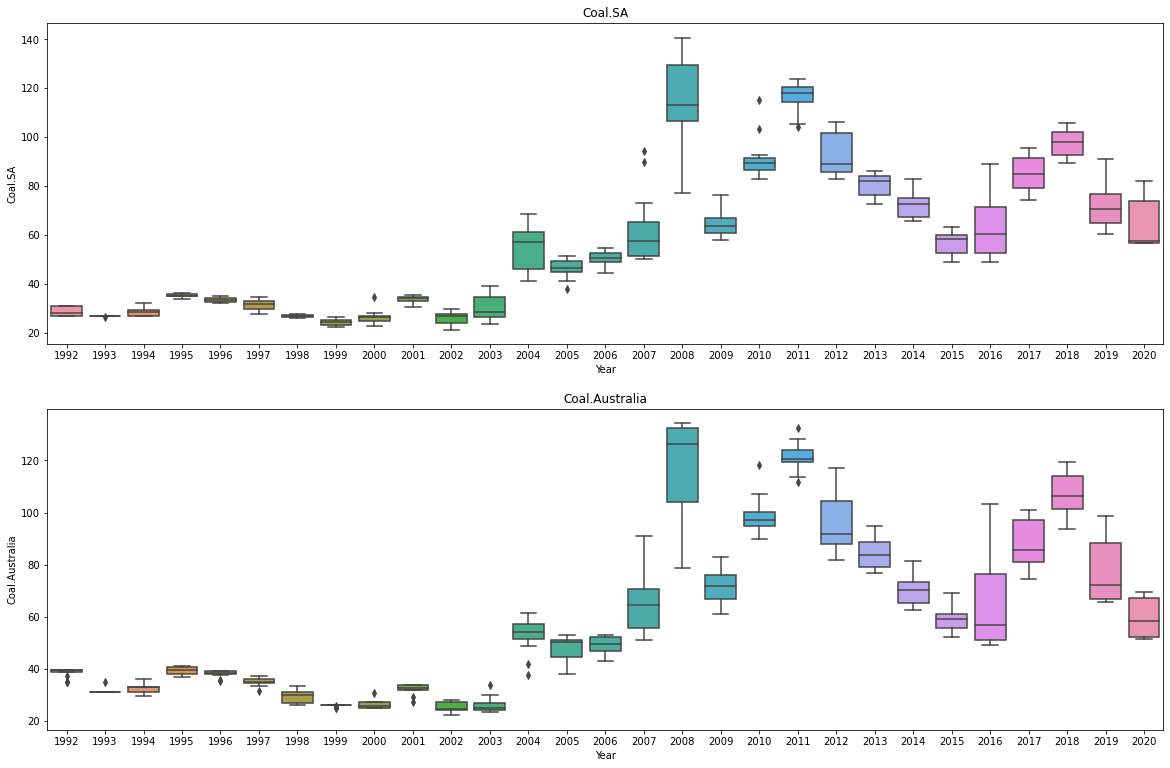

In [35]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='Coal.SA',ax=ax3[0]).set_title("Coal.SA")
sns.boxplot(data=df, x='Year', y='Coal.Australia',ax=ax3[1]).set_title("Coal.Australia")

Text(0.5, 1.0, 'Coal.Producer.Index')

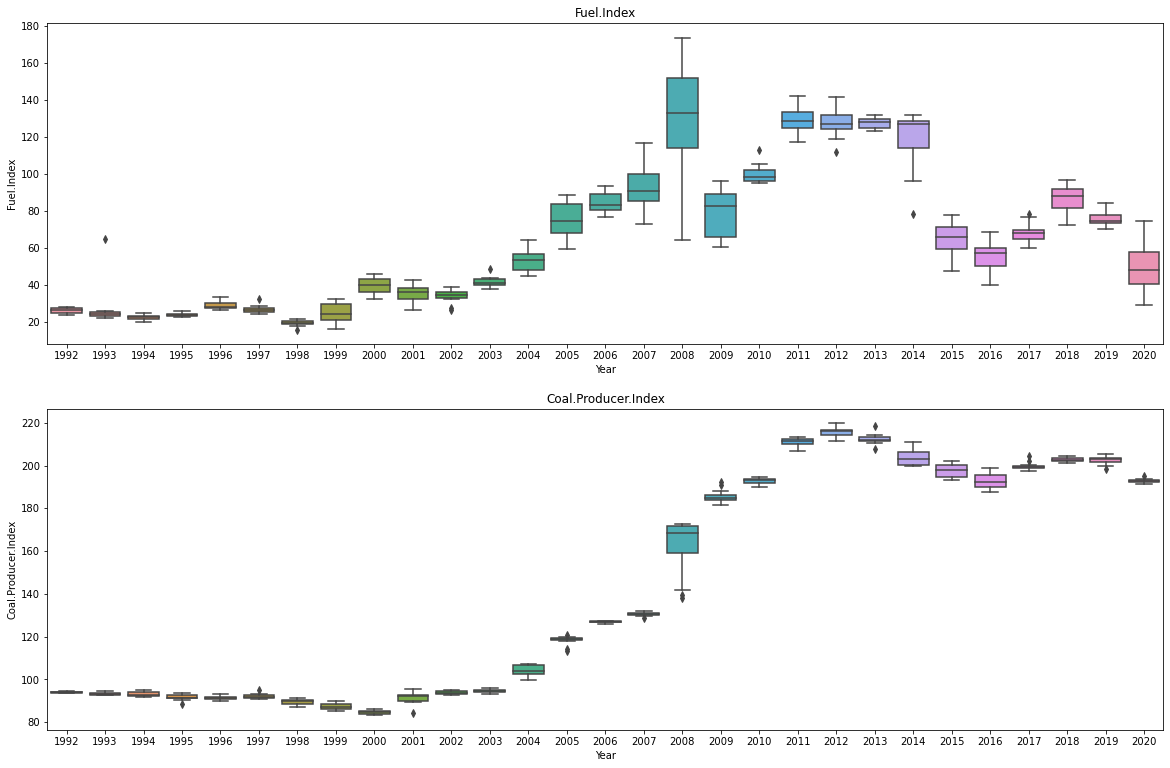

In [36]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='Fuel.Index',ax=ax3[0]).set_title("Fuel.Index")
sns.boxplot(data=df, x='Year', y='Coal.Producer.Index',ax=ax3[1]).set_title("Coal.Producer.Index")

Text(0.5, 1.0, 'CrudeOil.Index')

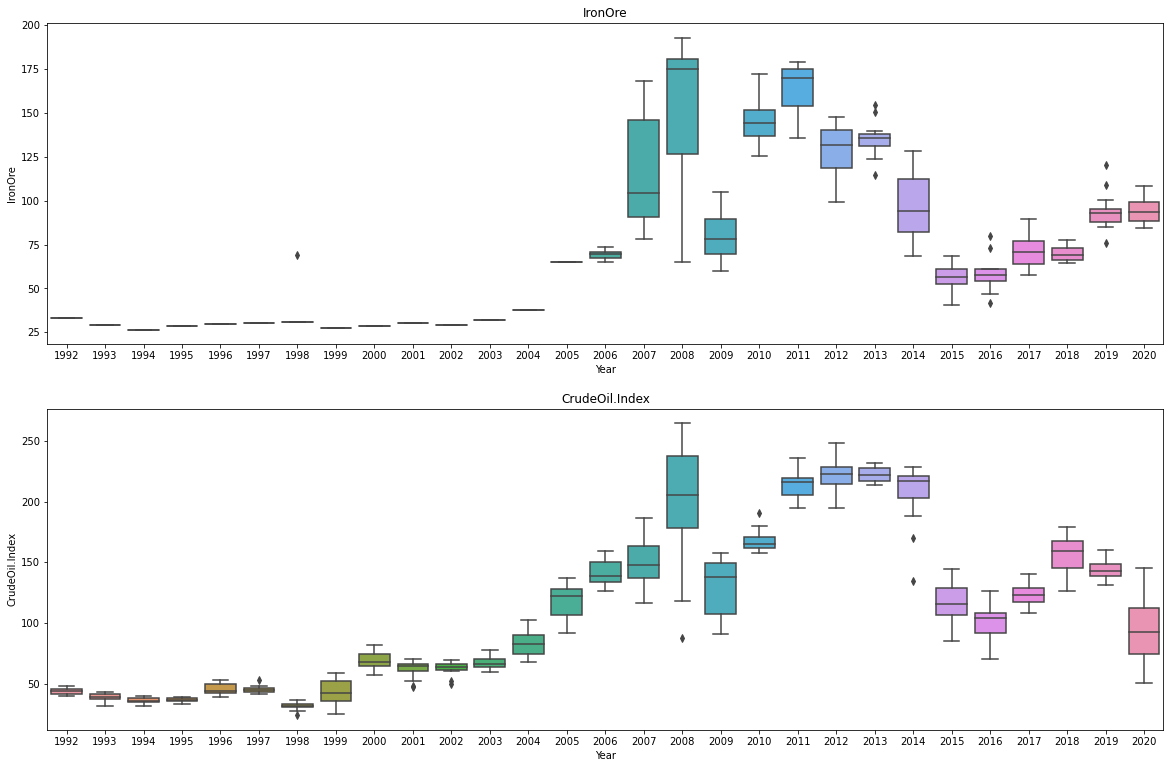

In [37]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='IronOre',ax=ax3[0]).set_title("IronOre")
sns.boxplot(data=df, x='Year', y='CrudeOil.Index',ax=ax3[1]).set_title("CrudeOil.Index")

Text(0.5, 1.0, 'Commodity.Index')

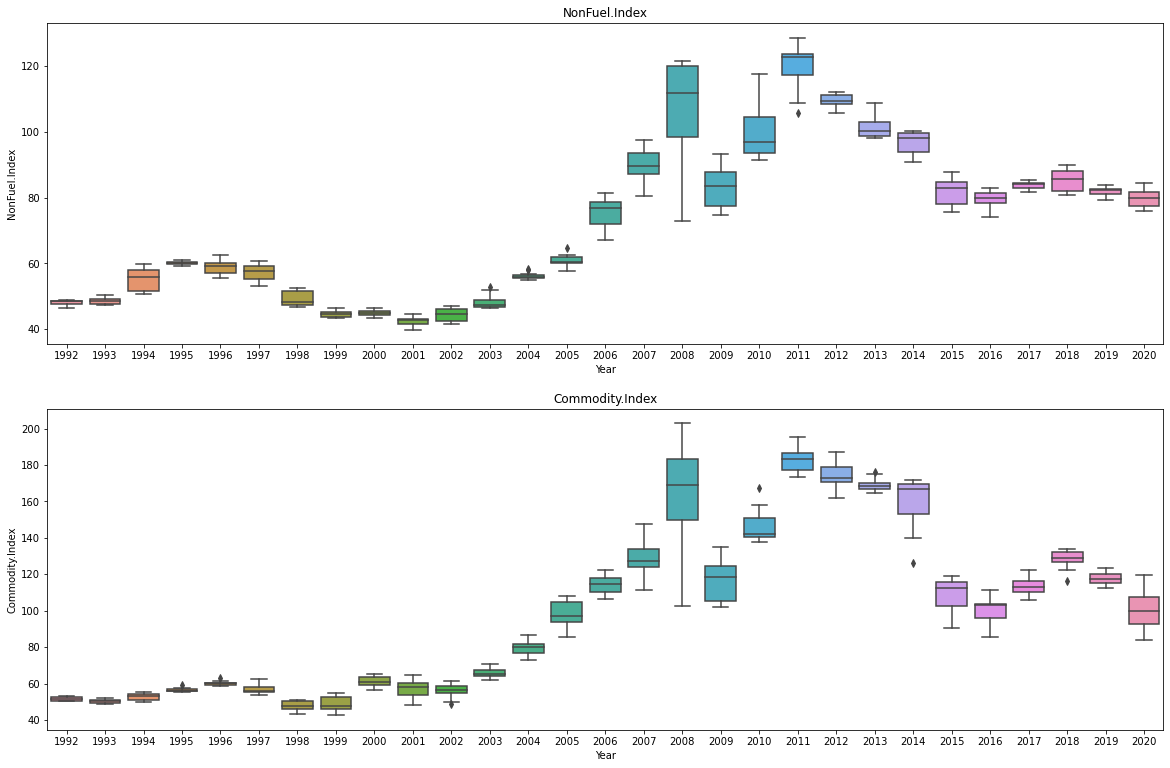

In [38]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='NonFuel.Index',ax=ax3[0]).set_title("NonFuel.Index")
sns.boxplot(data=df, x='Year', y='Commodity.Index',ax=ax3[1]).set_title("Commodity.Index")

Text(0.5, 1.0, 'Metal.Index')

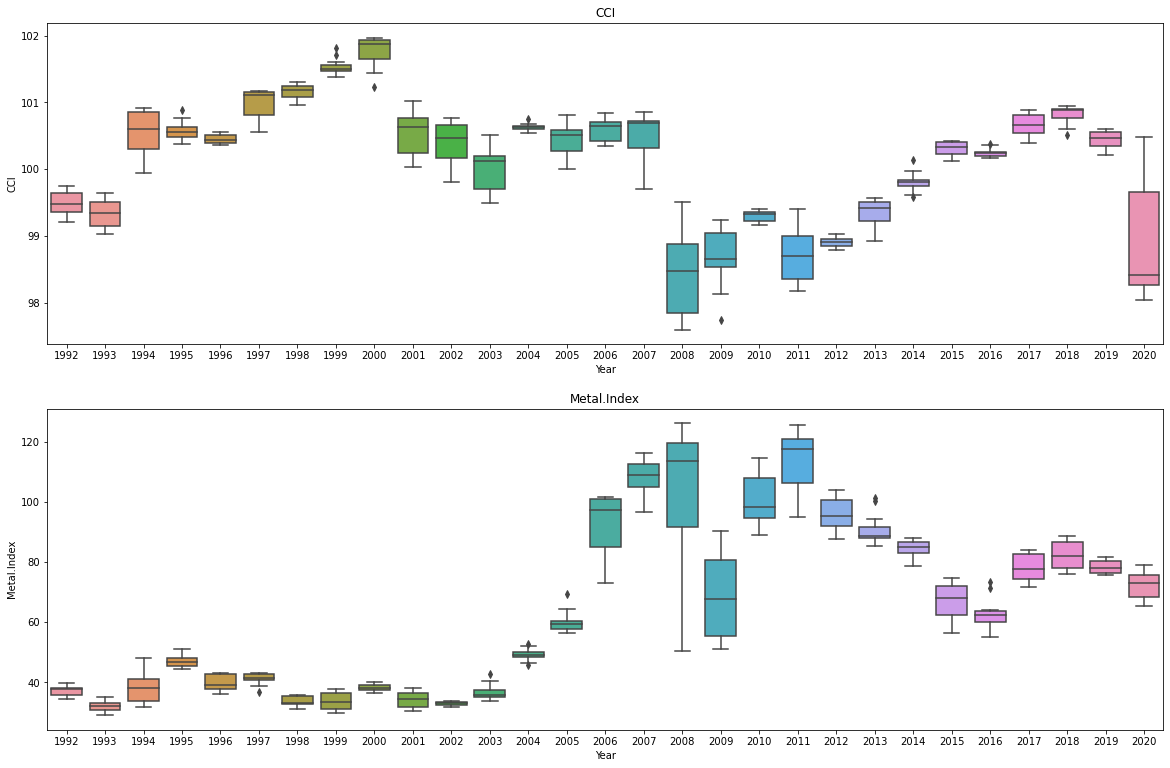

In [39]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year',ax=ax3[0],y='CCI').set_title("CCI")
sns.boxplot(data=df, x='Year',ax=ax3[1],y='Metal.Index').set_title("Metal.Index")

As we can see, from year perspective,in most of the attributes we have outliers. 

### Replacing the Outliers
We will detect outliers using IQR score. And if they are below the lower whisker, we will assign lower_whisker + 1 to those values, and if they are above the upper whisker we will assign upper_whisker - 1. 

In [40]:
#for Coal.SA
years = [1993,2000,2007,2010,2005,2011]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.SA",year,"Year")
            if(df['Coal.SA'][ind] > Upper_Whisker):
                df.replace(df['Coal.SA'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.SA'][ind] < Lower_Whisker):
                df.replace(df['Coal.SA'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

In [41]:
#For Coal.Aus
years = [1993,1992,1997,1999,1996,2001,2003,2004,2010,2000,2011]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.Australia",year,"Year")
            if(df['Coal.Australia'][ind] > Upper_Whisker):
                df.replace(df['Coal.Australia'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.Australia'][ind] < Lower_Whisker):
                df.replace(df['Coal.Australia'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

Text(0.5, 1.0, 'Coal.Australia after Outlier Removal')

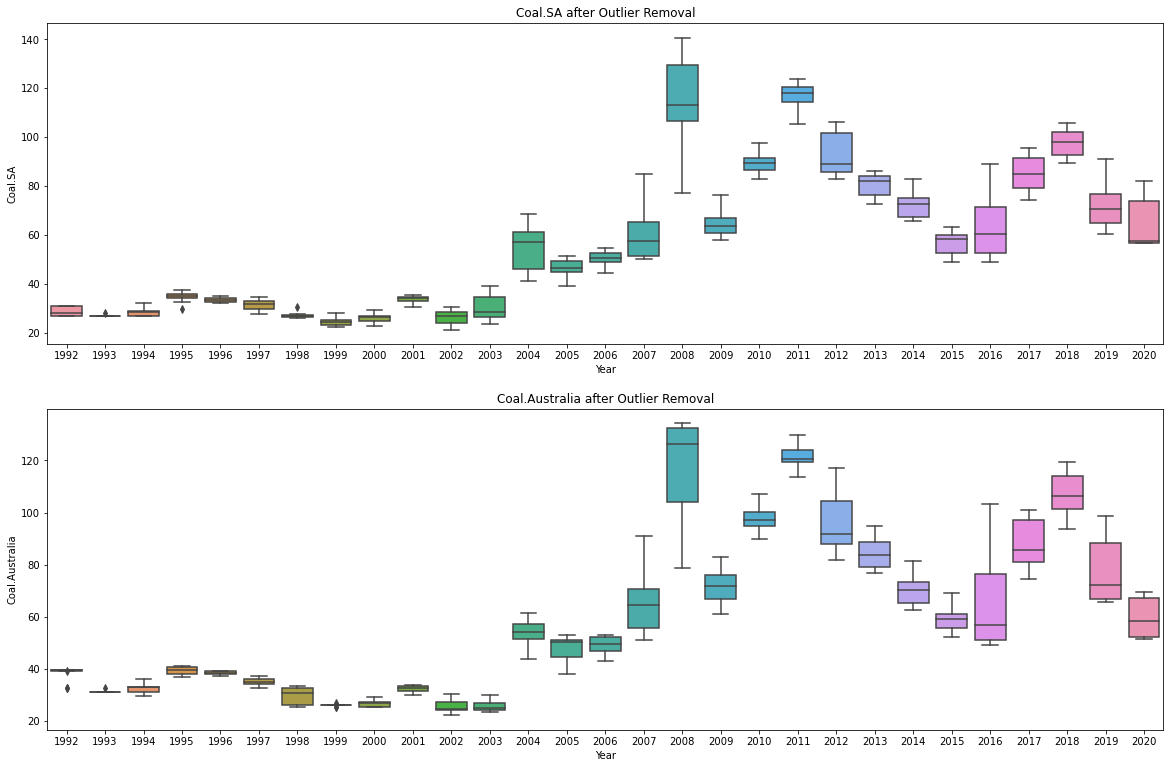

In [43]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='Coal.SA',ax=ax3[0]).set_title("Coal.SA after Outlier Removal")
sns.boxplot(data=df, x='Year', y='Coal.Australia',ax=ax3[1]).set_title("Coal.Australia after Outlier Removal")

In [44]:
#For Fuel.Index
years = [1993,1998,1997,2002,2003,2012,2010,2014]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Fuel.Index",year,"Year")
            if(df['Fuel.Index'][ind] > Upper_Whisker):
                df.replace(df['Fuel.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Fuel.Index'][ind] < Lower_Whisker):
                df.replace(df['Fuel.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 


In [45]:
#For Coal Producer Index
years = [1995,2001,1997,2005,2007,2008,2009,2013,2017,2019,2020]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.Producer.Index",year,"Year")
            if(df['Coal.Producer.Index'][ind] > Upper_Whisker):
                df.replace(df['Coal.Producer.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.Producer.Index'][ind] < Lower_Whisker):
                df.replace(df['Coal.Producer.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

Text(0.5, 1.0, 'Coal.Producer.Index after Outlier Removal')

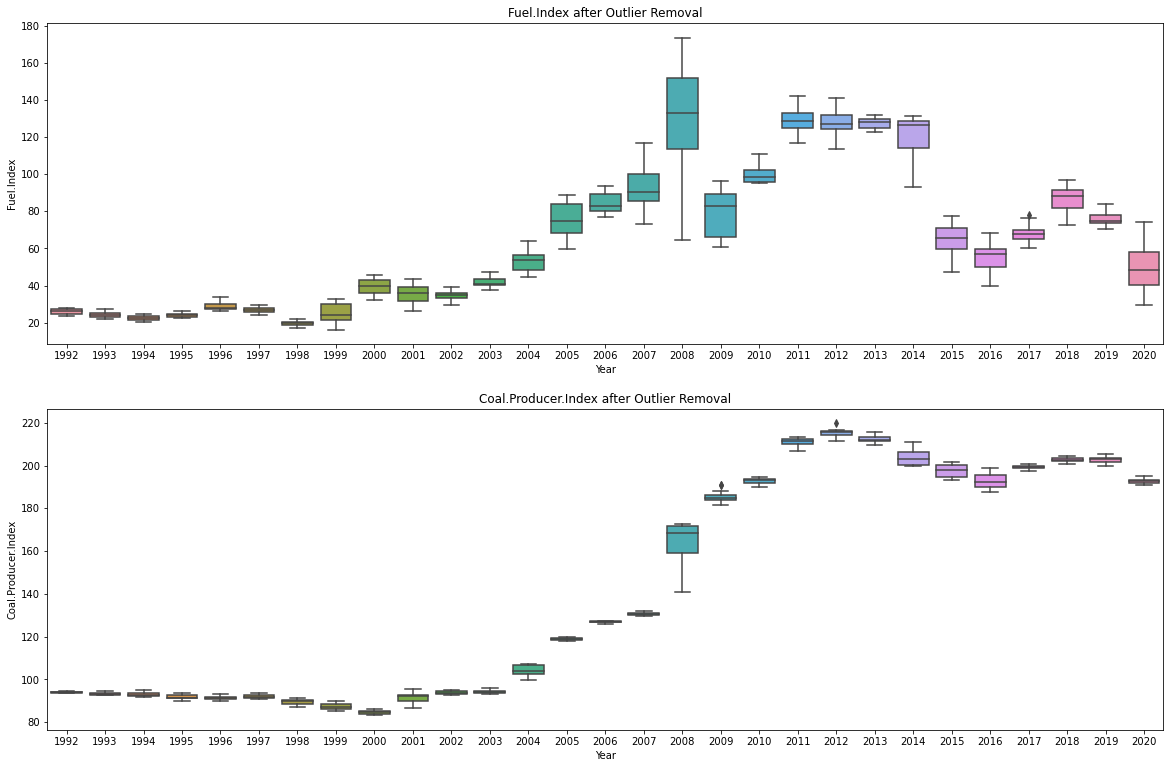

In [46]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='Fuel.Index',ax=ax3[0]).set_title("Fuel.Index after Outlier Removal")
sns.boxplot(data=df, x='Year', y='Coal.Producer.Index',ax=ax3[1]).set_title("Coal.Producer.Index after Outlier Removal")

In [47]:
#For IronOre
years = [1998,2016,2013,2019]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("IronOre",year,"Year")
            if(df['IronOre'][ind] > Upper_Whisker):
                df.replace(df['IronOre'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['IronOre'][ind] < Lower_Whisker):
                df.replace(df['IronOre'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

In [48]:
#For Crude.Oil.Index
years = [1997,1998,2001,2002,2008,2010,2014,2016,2013,2019]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("CrudeOil.Index",year,"Year")
            if(df['CrudeOil.Index'][ind] > Upper_Whisker):
                df.replace(df['CrudeOil.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['CrudeOil.Index'][ind] < Lower_Whisker):
                df.replace(df['CrudeOil.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

Text(0.5, 1.0, 'CrudeOil.Index after Outlier Removal')

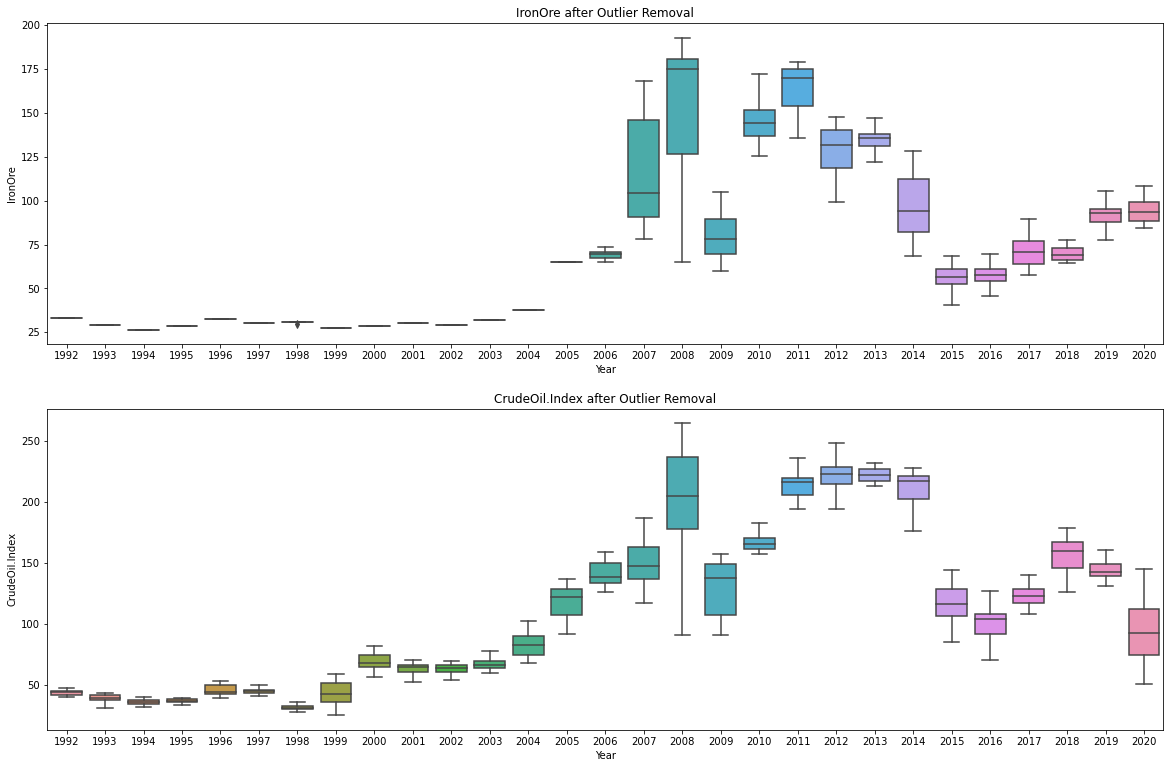

In [49]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='IronOre',ax=ax3[0]).set_title("IronOre after Outlier Removal")
sns.boxplot(data=df, x='Year', y='CrudeOil.Index',ax=ax3[1]).set_title("CrudeOil.Index after Outlier Removal")

In [50]:
#For Non-Fuel Index
years = [2003,2004,2005,2011]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("NonFuel.Index",year,"Year")
            if(df['NonFuel.Index'][ind] > Upper_Whisker):
                df.replace(df['NonFuel.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['NonFuel.Index'][ind] < Lower_Whisker):
                df.replace(df['NonFuel.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 


In [51]:
#For Commodity.Oil.Index
years = [1995,1996,2002,2013,2010,2014,2018]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Commodity.Index",year,"Year")
            if(df['Commodity.Index'][ind] > Upper_Whisker):
                df.replace(df['Commodity.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Commodity.Index'][ind] < Lower_Whisker):
                df.replace(df['Commodity.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

Text(0.5, 1.0, 'Commodity.Index after Outlier Removal')

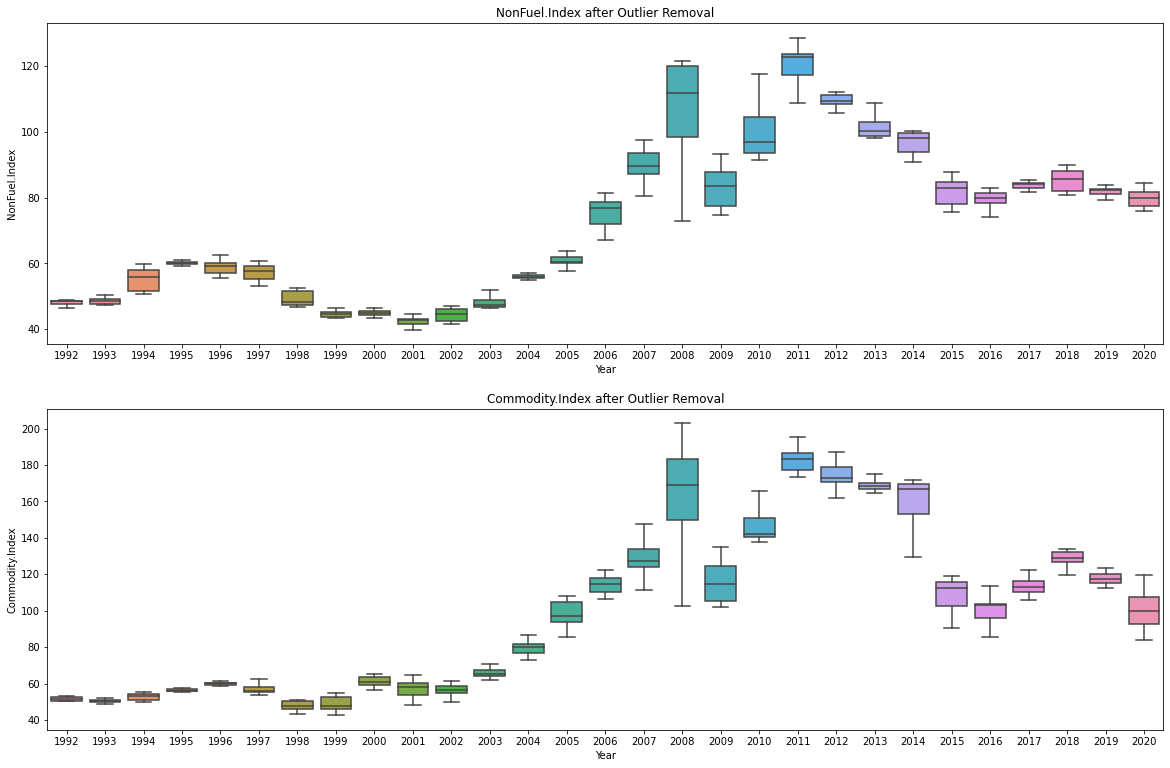

In [52]:
ffig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='NonFuel.Index',ax=ax3[0]).set_title("NonFuel.Index after Outlier Removal")
sns.boxplot(data=df, x='Year', y='Commodity.Index',ax=ax3[1]).set_title("Commodity.Index after Outlier Removal")

In [53]:
#For CCI
years = [1995,1999,2000,2004,2009,2014,2016,2018]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("CCI",year,"Year")
            if(df['CCI'][ind] > Upper_Whisker):
                df.replace(df['CCI'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['CCI'][ind] < Lower_Whisker):
                df.replace(df['CCI'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 


In [54]:
#For Metal Index
years = [2003,2004,2005,2013,2016,1997]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Metal.Index",year,"Year")
            if(df['Metal.Index'][ind] > Upper_Whisker):
                df.replace(df['Metal.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Metal.Index'][ind] < Lower_Whisker):
                df.replace(df['Metal.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

In [61]:
df=df.sort_index()

Text(0.5, 1.0, 'Metal.Index after Outlier Removal')

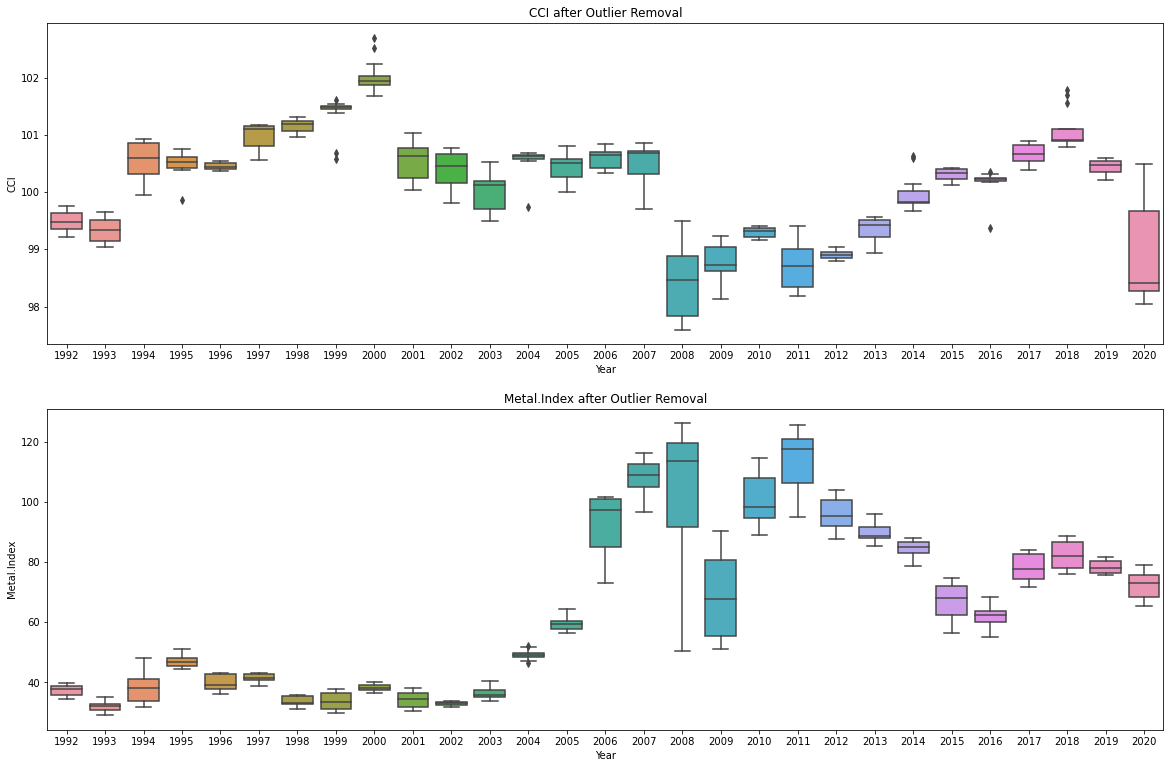

In [55]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year',ax=ax3[0],y='CCI').set_title("CCI after Outlier Removal")
sns.boxplot(data=df, x='Year',ax=ax3[1],y='Metal.Index').set_title("Metal.Index after Outlier Removal")

We handled outliers in years perspective as seen in the graphs. We believe the reason for the outliers is the economic crise in 2008. There was a sharp slowdown in demand,and with mining output remaining stubbornly high. Therefore, coal benchmarks fell down.

## Stationarity 

As mentioned in the trend section, we need to further check stationarity using these methods:

ADF plot: If most of the (95%) autocorrelation values are within the confidence interval, we can conclude that the series is stationary.

Dickey-Fuller Test: The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the test statistic is less than the critical value (0.05), we can say that time series is stationary.

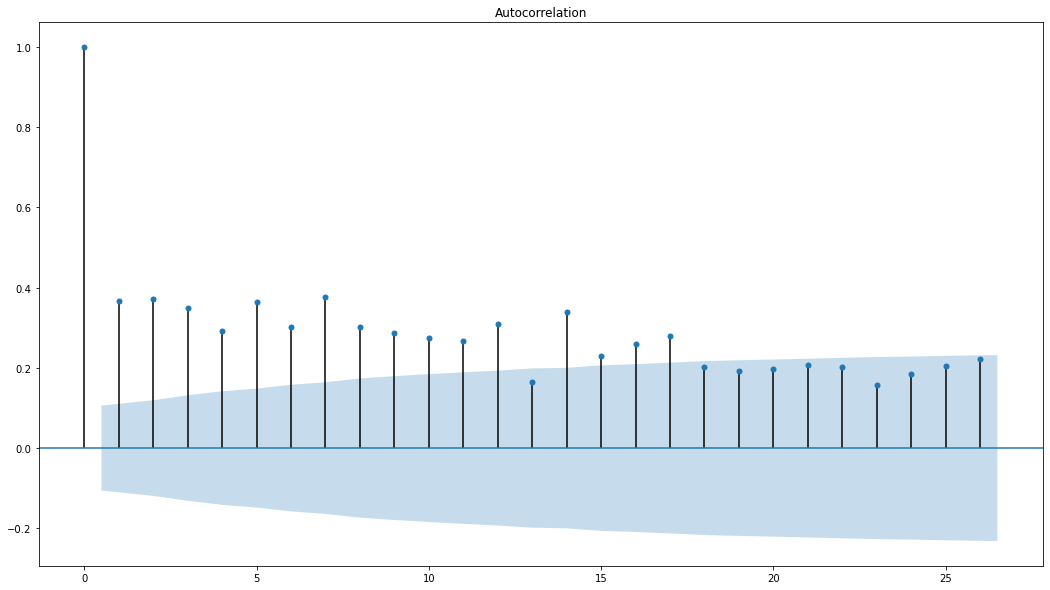

In [56]:
plot_acf(df["Coal.SA"]);

Looking at the ACF plot, since none of the lags are within the confidence interval, we can conclude that the Coal.SA series is non-stationary.

In [57]:
from statsmodels.tsa.stattools import adfuller
# check for stationarity
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [58]:
adf_test(df["Coal.SA"],title='')  

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.238759
p-value                   0.192480
# lags used              13.000000
# observations          329.000000
critical value (1%)      -3.450384
critical value (5%)      -2.870365
critical value (10%)     -2.571472
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [59]:
adf_test(df["Coal.SA"].apply(lambda x: np.log(x)).diff(periods=1), title='')     

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.672631e+00
p-value                 4.503251e-14
# lags used             1.200000e+01
# observations          3.290000e+02
critical value (1%)    -3.450384e+00
critical value (5%)    -2.870365e+00
critical value (10%)   -2.571472e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In order to make the series stationary, we are using differencing to trend effects from the original series.

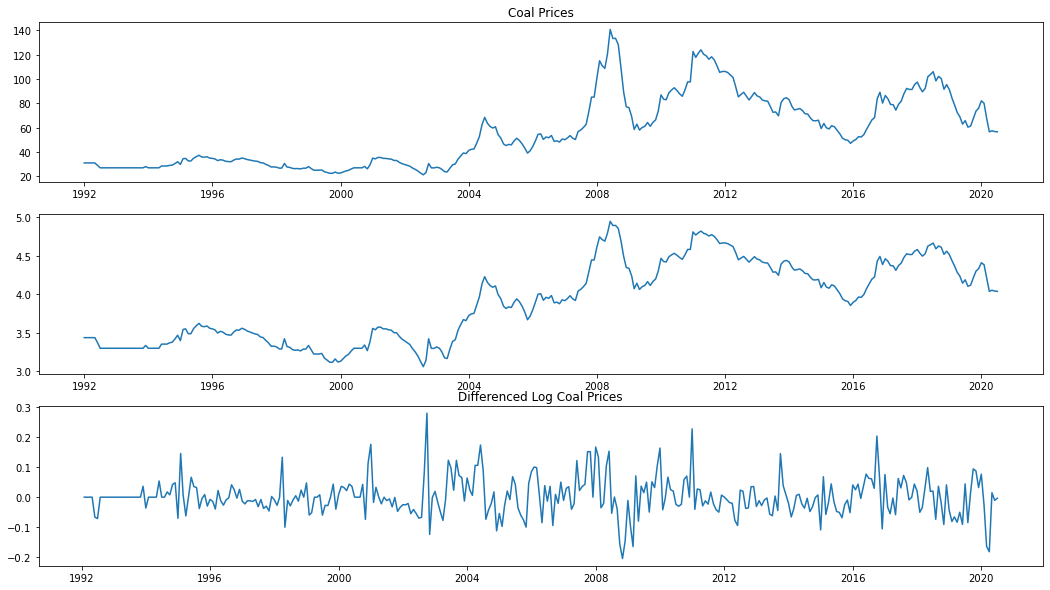

In [62]:
fig, ax = plt.subplots(3);
ax[0].plot(df["Coal.SA"]);
ax[0].set_title("Coal Prices")
ax[1].plot(np.log(df["Coal.SA"]))
ax[2].plot(df["Coal.SA"].apply(lambda x: np.log(x)).diff(periods=1));
ax[2].set_title("Differenced Log Coal Prices");

Looking at the time plots, the differenced series look a lot more stationary than the original series. We need to further inspect using ADF method as mentioned above.

# ARIMA

(p,d,q) is parameters of ARIMA model.

In order to choose p,d,q parameters we will use two different plots.

1) Autocorrelation Function (ACF): Measurement of the correlation between time series and lagged version of time series.

2) Partial Autocorrelation Function (PACF): This measures the correlation between the time series and lagged version of time series but after eliminating the variations already explained by the intervening comparisons.



In [64]:
ts=df["Coal.SA"].apply(lambda x: np.log(x)).diff(periods=1).dropna()

In [65]:

features = df
final_features = features.drop(['Year','Month','Seasonally Adjusted','Trend/Seasonal Adjusted'], axis=1)
final_features.shape

(343, 10)

In [66]:
for_exog_array = final_features
for_exog_array = for_exog_array.drop(['Coal.SA'], axis=1)
#for_exog_array
exog = for_exog_array.to_numpy()
exog.shape

(343, 9)

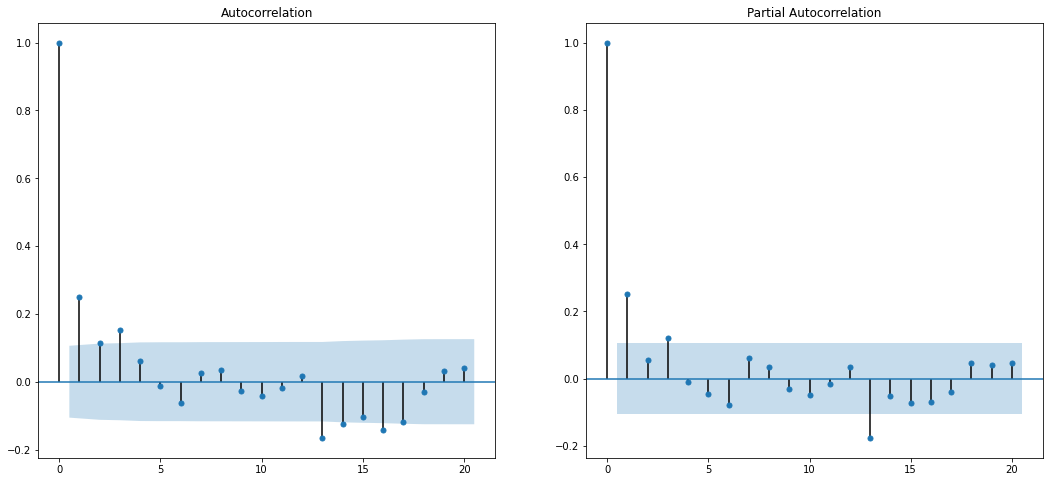

In [67]:
fig, ax = plt.subplots(1,2)
plot_acf(ts, lags=20, ax=ax[0]);
plot_pacf(ts, lags=20, ax=ax[1]);

Two dotted lines are the confidence interevals. We use these lines to determine the ‘p’ and ‘q’ values

The data may follow an ARIMA(p,d,0) model if the ACF and PACF plots of the differenced data show the following patterns:

    the ACF is exponentially decaying or sinusoidal;
    
    there is a significant spike at lag  p in the PACF, but none beyond lag p.

The data may follow an ARIMA(0, d, q) model if the ACF and PACF plots of the differenced data show the following patterns:

    the PACF is exponentially decaying or sinusoidal;
    
    there is a significant spike at lag  q in the ACF, but none beyond lag q.

Looking at the PACF plot, we can say that there is a significant spike at lag 1 and none beyond lag 1, therefore ARIMA(1,0,0) is a strong candidate. Of course, when we use the original series (not differenced), we need to use ARIMA(1,1,0) to account for differencing.

In [68]:
from pandas import datetime
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")
# fit model
#model=sm.tsa.statespace.SARIMAX(df['Coal.SA'],order=(1, 1, 0),seasonal_order=(0,0,0,0))
model = SARIMAX(df['Coal.SA'], order=(1,1,0), seasonal_order=(0,0,0,13), exog=exog)
model_fit = model.fit(disp=0)
print(model_fit.summary())

results=model.fit()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


                           Statespace Model Results                           
Dep. Variable:                Coal.SA   No. Observations:                  343
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -844.988
Date:                Sun, 30 May 2021   AIC                           1711.975
Time:                        01:22:11   BIC                           1754.158
Sample:                    01-01-1992   HQIC                          1728.780
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5662      0.026     21.442      0.000       0.514       0.618
x2             0.0846      0.101      0.836      0.403      -0.114       0.283
x3             0.0548      0.033      1.682      0.0

## Forecasting

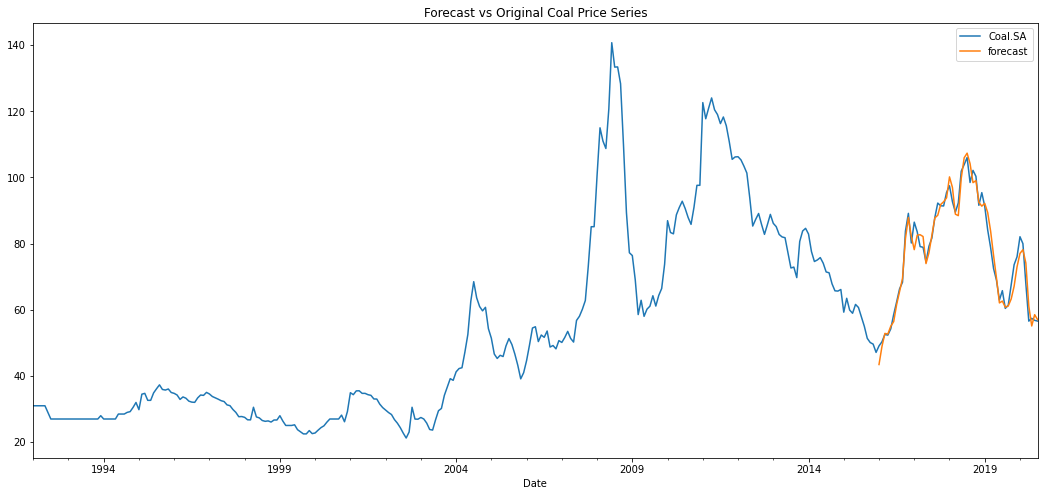

In [69]:
# predict from and to these dates
start_index = datetime(2016, 1, 1)
end_index = datetime(2020, 7, 1)

df['forecast']=results.predict(start=start_index, end=end_index)
df[['Coal.SA','forecast']].plot();
plt.title("Forecast vs Original Coal Price Series");

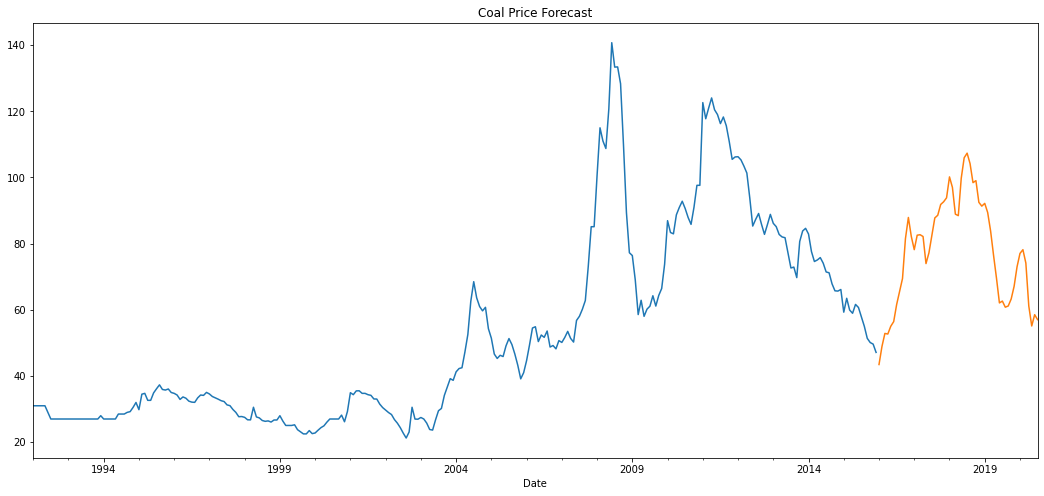

In [70]:
df["Coal.SA"][:-55].plot();
df['forecast'].plot();
plt.title("Coal Price Forecast");

In [71]:
from sklearn.metrics import mean_squared_error, r2_score
actual=df["Coal.SA"][-55:]
forecast=df["forecast"][-55:]
actual =actual.values
error = mean_squared_error(actual, forecast, squared = False)
#let's calculate the metric R^2 to compare all models
#import sklearn.metrics as sm
print("RMSE =",error)
print("R^2 score =", round(r2_score(actual, forecast), 2))
# if R^2 is nearly 1, it's the best case.

RMSE = 3.1124075980119326
R^2 score = 0.96


# **2nd Model**

In [72]:
model2 = SARIMAX(df['Coal.SA'], order=(0,1,1), seasonal_order=(0,0,0,0), exog=exog)
model_fit2 = model2.fit(disp=0)
print(model_fit2.summary())

results2 = model2.fit()

                           Statespace Model Results                           
Dep. Variable:                Coal.SA   No. Observations:                  343
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -844.985
Date:                Sun, 30 May 2021   AIC                           1711.970
Time:                        01:22:54   BIC                           1754.152
Sample:                    01-01-1992   HQIC                          1728.774
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5677      0.027     21.346      0.000       0.516       0.620
x2             0.0863      0.100      0.859      0.390      -0.111       0.283
x3             0.0551      0.032      1.698      0.0

In [73]:
df['forecast2'] = results2.predict(start=start_index, end=end_index)
forecast2 = df["forecast2"][-55:]

error2 = mean_squared_error(actual, forecast2, squared = False)
#let's calculate the metric R^2 to compare all models
#import sklearn.metrics as sm
print("RMSE =",error2)
print("R^2 score =", round(r2_score(actual, forecast2), 2))
# if R^2 is nearly 1, it's the best case.

RMSE = 3.108349863243651
R^2 score = 0.96


# **SARIMAX Model- 7 Parameters**

In [74]:
import itertools
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 13) for x in list(itertools.product(p,d,q))]
print("examples of parameter combinations or Seasonal ARIMA...")
print("SARIMAX: {} * {}".format(pdq[1], seasonal_pdq[1]))
print("SARIMAX: {} * {}".format(pdq[1], seasonal_pdq[2]))
print("SARIMAX: {} * {}".format(pdq[2], seasonal_pdq[3]))
print("SARIMAX: {} * {}".format(pdq[2], seasonal_pdq[4]))
print("SARIMAX: {} * {}".format(pdq[3], seasonal_pdq[5]))



examples of parameter combinations or Seasonal ARIMA...
SARIMAX: (0, 0, 1) * (0, 0, 1, 13)
SARIMAX: (0, 0, 1) * (0, 1, 0, 13)
SARIMAX: (0, 1, 0) * (0, 1, 1, 13)
SARIMAX: (0, 1, 0) * (1, 0, 0, 13)
SARIMAX: (0, 1, 1) * (1, 0, 1, 13)


In [77]:
metric_aic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
      model_test = SARIMAX(df['Coal.SA'], order=pm, seasonal_order=pm_seasonal, exog=exog)
      model_aic = model_test.fit()
      print('ARIMA{}x{}12 - AIC:{}'.format(pm, pm_seasonal, model_aic.aic))
      metric_aic_dict.update({(pm, pm_seasonal):model_aic.aic})
    except:
      continue


ARIMA(0, 0, 0)x(0, 0, 0, 13)12 - AIC:1959.2245238268522
ARIMA(0, 0, 0)x(0, 0, 1, 13)12 - AIC:1960.6235939667538
ARIMA(0, 0, 0)x(0, 1, 0, 13)12 - AIC:2020.043974420261
ARIMA(0, 0, 0)x(0, 1, 1, 13)12 - AIC:1934.7552529275458
ARIMA(0, 0, 0)x(1, 0, 0, 13)12 - AIC:1960.5244618016986
ARIMA(0, 0, 0)x(1, 0, 1, 13)12 - AIC:1962.4640284305917
ARIMA(0, 0, 0)x(1, 1, 0, 13)12 - AIC:1947.4213156854719
ARIMA(0, 0, 0)x(1, 1, 1, 13)12 - AIC:1932.6134325360351
ARIMA(0, 0, 1)x(0, 0, 0, 13)12 - AIC:1817.2282541230143
ARIMA(0, 0, 1)x(0, 0, 1, 13)12 - AIC:1818.4122982673312
ARIMA(0, 0, 1)x(0, 1, 0, 13)12 - AIC:1925.363601368267
ARIMA(0, 0, 1)x(0, 1, 1, 13)12 - AIC:1796.6530802120622
ARIMA(0, 0, 1)x(1, 0, 0, 13)12 - AIC:1818.258806004173
ARIMA(0, 0, 1)x(1, 0, 1, 13)12 - AIC:1820.2531342678517
ARIMA(0, 0, 1)x(1, 1, 0, 13)12 - AIC:1837.928807999504
ARIMA(0, 0, 1)x(1, 1, 1, 13)12 - AIC:1797.369921655424
ARIMA(0, 1, 0)x(0, 0, 0, 13)12 - AIC:1715.7457118230698
ARIMA(0, 1, 0)x(0, 0, 1, 13)12 - AIC:1717.11519574286

In [75]:
metric_bic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
      model_test2 = SARIMAX(df['Coal.SA'], order=pm, seasonal_order=pm_seasonal, exog=exog)
      model_bic = model_test2.fit()
      print('ARIMA{}x{}12 - BIC:{}'.format(pm, pm_seasonal, model_bic.bic))
      metric_bic_dict.update({(pm, pm_seasonal):model_bic.bic})
    except:
      continue

ARIMA(0, 0, 0)x(0, 0, 0, 13)12 - BIC:1997.6018282985117
ARIMA(0, 0, 0)x(0, 0, 1, 13)12 - BIC:2002.838628885579
ARIMA(0, 0, 0)x(0, 1, 0, 13)12 - BIC:2058.034900964866
ARIMA(0, 0, 0)x(0, 1, 1, 13)12 - BIC:1976.5452721266115
ARIMA(0, 0, 0)x(1, 0, 0, 13)12 - BIC:2002.739496720524
ARIMA(0, 0, 0)x(1, 0, 1, 13)12 - BIC:2008.516793796583
ARIMA(0, 0, 0)x(1, 1, 0, 13)12 - BIC:1989.2113348845376
ARIMA(0, 0, 0)x(1, 1, 1, 13)12 - BIC:1978.2025443895614
ARIMA(0, 0, 1)x(0, 0, 0, 13)12 - BIC:1859.4432890418395
ARIMA(0, 0, 1)x(0, 0, 1, 13)12 - BIC:1864.4650636333224
ARIMA(0, 0, 1)x(0, 1, 0, 13)12 - BIC:1967.1536205673326
ARIMA(0, 0, 1)x(0, 1, 1, 13)12 - BIC:1842.2421920655884
ARIMA(0, 0, 1)x(1, 0, 0, 13)12 - BIC:1864.3115713701643
ARIMA(0, 0, 1)x(1, 0, 1, 13)12 - BIC:1870.143630081009
ARIMA(0, 0, 1)x(1, 1, 0, 13)12 - BIC:1883.5179198530302
ARIMA(0, 0, 1)x(1, 1, 1, 13)12 - BIC:1846.7581261634107
ARIMA(0, 1, 0)x(0, 0, 0, 13)12 - BIC:1754.0938191936957
ARIMA(0, 1, 0)x(0, 0, 1, 13)12 - BIC:1759.29811385055

In [89]:
#{k: v for k,v in sorted(metric_aic_dict.items(), key = lambda x: x[1])}

sorted_aic = sorted(metric_aic_dict.items(), key=operator.itemgetter(1))
sorted_aic

[(((1, 0, 0), (0, 1, 1, 13)), 1678.748527153305),
 (((1, 0, 1), (0, 1, 1, 13)), 1679.3924844596313),
 (((1, 0, 0), (1, 1, 1, 13)), 1680.2186262016742),
 (((1, 0, 1), (1, 1, 1, 13)), 1681.084441756757),
 (((1, 1, 1), (0, 1, 1, 13)), 1683.589658313551),
 (((1, 1, 1), (1, 1, 1, 13)), 1686.0214594109),
 (((0, 1, 1), (0, 1, 1, 13)), 1690.9751716109754),
 (((1, 1, 0), (0, 1, 1, 13)), 1690.9879711052179),
 (((0, 1, 1), (1, 1, 1, 13)), 1692.7901921876355),
 (((1, 1, 0), (1, 1, 1, 13)), 1692.793306628365),
 (((0, 1, 0), (0, 1, 1, 13)), 1693.9893026196983),
 (((0, 1, 0), (1, 1, 1, 13)), 1695.2877534663721),
 (((1, 0, 0), (0, 0, 0, 13)), 1698.7952706380038),
 (((1, 0, 1), (0, 0, 0, 13)), 1699.4395522935492),
 (((1, 0, 0), (1, 0, 0, 13)), 1700.4937336836463),
 (((1, 0, 0), (0, 0, 1, 13)), 1700.5031929987786),
 (((1, 0, 1), (0, 0, 1, 13)), 1701.299161141339),
 (((1, 0, 1), (1, 0, 0, 13)), 1701.300249931522),
 (((1, 0, 0), (1, 0, 1, 13)), 1702.4629009426935),
 (((1, 0, 1), (1, 0, 1, 13)), 1703.28300

In [118]:
import operator
#test_x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted_bic = sorted(metric_bic_dict.items(), key=operator.itemgetter(1))
sorted_bic


[(((1, 0, 0), (0, 1, 1, 13)), 1724.3376390068313),
 (((1, 0, 1), (0, 1, 1, 13)), 1728.780688967618),
 (((1, 0, 0), (1, 1, 1, 13)), 1729.606830709661),
 (((1, 1, 1), (0, 1, 1, 13)), 1732.9384090735007),
 (((1, 0, 1), (1, 1, 1, 13)), 1734.2717389192044),
 (((0, 1, 0), (0, 1, 1, 13)), 1735.7459378781173),
 (((0, 1, 1), (0, 1, 1, 13)), 1736.5278646201598),
 (((1, 1, 0), (0, 1, 1, 13)), 1736.5406641144023),
 (((1, 1, 1), (1, 1, 1, 13)), 1739.1662679216151),
 (((0, 1, 0), (1, 1, 1, 13)), 1740.8404464755565),
 (((1, 0, 0), (0, 0, 0, 13)), 1741.010305556829),
 (((0, 1, 1), (1, 1, 1, 13)), 1742.1389429475853),
 (((1, 1, 0), (1, 1, 1, 13)), 1742.1420573883147),
 (((1, 0, 1), (0, 0, 0, 13)), 1745.4923176595405),
 (((1, 0, 0), (1, 0, 0, 13)), 1746.5464990496375),
 (((1, 0, 0), (0, 0, 1, 13)), 1746.5559583647698),
 (((1, 0, 1), (0, 0, 1, 13)), 1751.1896569544963),
 (((1, 0, 1), (1, 0, 0, 13)), 1751.1907457446794),
 (((1, 0, 0), (1, 0, 1, 13)), 1752.3533967558508),
 (((0, 1, 0), (0, 0, 0, 13)), 1754

# **FINAL MODEL**

In [119]:
final_model = SARIMAX(df['Coal.SA'], order=(1,0,0), seasonal_order=(0,1,1,13), exog=exog)
final_model_fit = final_model.fit(disp=0)
print(final_model_fit.summary())

final_results = final_model.fit()

                                 Statespace Model Results                                 
Dep. Variable:                            Coal.SA   No. Observations:                  343
Model:             SARIMAX(1, 0, 0)x(0, 1, 1, 13)   Log Likelihood                -827.374
Date:                            Sun, 30 May 2021   AIC                           1678.749
Time:                                    02:20:22   BIC                           1724.338
Sample:                                01-01-1992   HQIC                          1696.933
                                     - 07-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5847      0.028     20.717      0.000       0.529       0.640
x2             0.1109      0.111   

In [120]:
df['forecast_f'] = final_results.predict(start=start_index, end=end_index)
forecast_f = df["forecast_f"][-55:]

final_error = mean_squared_error(actual, forecast_f, squared = False)
#let's calculate the metric R^2 to compare all models
#import sklearn.metrics as sm
print("RMSE =",final_error)
print("R^2 score =", round(r2_score(actual, forecast_f), 2))
# if R^2 is nearly 1, it's the best case.

RMSE = 3.0006938527844476
R^2 score = 0.96


# LSTM Model

In [15]:
# importing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import layers
from keras import activations

import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [16]:
# rearranging dataframe columns to have target column at the first column
df = df[['Coal.SA','Coal.Australia', 'Fuel.Index', 'Coal.Producer.Index',
       'IronOre', 'CrudeOil.Index', 'Metal.Index', 'NonFuel.Index',
       'Commodity.Index', 'CCI']]

In [17]:
df.head()

Coal.SA  Coal.Australia  ...  Commodity.Index       CCI
Date                                 ...                           
1992-01-01     31.0            39.5  ...            50.72  99.36520
1992-02-01     31.0            39.5  ...            50.72  99.46713
1992-03-01     31.0            39.5  ...            50.75  99.62660
1992-04-01     31.0            39.5  ...            51.17  99.72688
1992-05-01     31.0            39.5  ...            52.64  99.75301

[5 rows x 10 columns]

### changing the timeseries data into supervised learning data (X,y) by shifting the dataframe to have target variable at time t with all the features until time t-1

In [18]:
#converting series to supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [19]:
# checking dataframe column value types
values = df.values
df.dtypes

Coal.SA                float64
Coal.Australia         float64
Fuel.Index             float64
Coal.Producer.Index    float64
IronOre                float64
CrudeOil.Index         float64
Metal.Index            float64
NonFuel.Index          float64
Commodity.Index        float64
CCI                    float64
dtype: object

In [21]:
# scaling full data using the MinMaxScaler, since all the column values are float
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(values)

# changing data to supervised data as described above
reframed_data = series_to_supervised(data_scaled, 1,1)

In [22]:
reframed_data.head()

var1(t-1)  var2(t-1)  var3(t-1)  ...   var8(t)   var9(t)  var10(t)
1   0.066553    0.10935   0.049397  ...  0.099537  0.050221  0.479446
2   0.066553    0.10935   0.050159  ...  0.099876  0.050409  0.512613
3   0.066553    0.10935   0.049905  ...  0.096603  0.053029  0.533470
4   0.066553    0.10935   0.059111  ...  0.097957  0.062200  0.538904
5   0.066553    0.10935   0.066032  ...  0.099876  0.063510  0.525446

[5 rows x 20 columns]

In [24]:
#only keep data till time t; t+1, t2, ...all till the end can be dropped
reframed_data.drop(['var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)',
       'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)'], axis=1, inplace=True)
print(reframed_data.head())

In [25]:
# storing dataframe as array 
values = reframed_data.values

In [27]:
# splitting data into 80% training and 20% testing
training_split= int(0.8*values.shape[0])
train = values[:training_split, :]
test = values[training_split:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D input [samples, timesteps, features] for LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

## LSTM Training

In [ ]:
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(layers.Activation(activations.relu))
model.add(Dropout(0.15))
model.add(LSTM(32, return_sequences = False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# viewing model summary
model.summary()

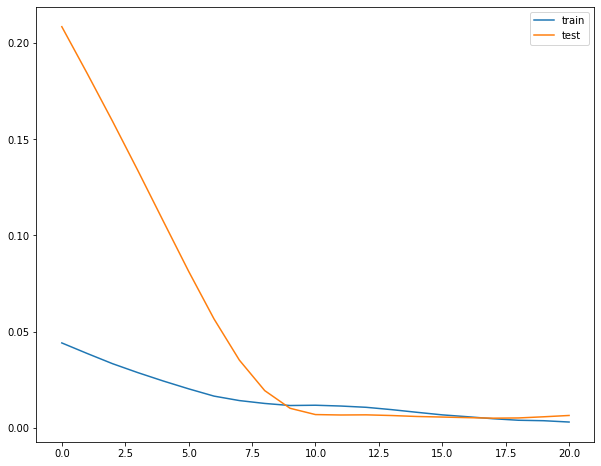

In [30]:
# add earlystopping callback for model training
es = EarlyStopping(monitor='val_loss', patience=3, mode='min')

# model training
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_split=0.2, verbose=2, shuffle=False, callbacks=[es])

# plot training and validation loss for the model
plt.plot(history.history['loss'], label='train')
plt.plot(histyhat = model.predict(test_X)ory.history['val_loss'], label='test')
plt.legend()
plt.show()

## Making predictions on the train data

In [32]:
# prediction on the test data
yhat = model.predict(test_X)

In [ ]:
# reversing the scaling for original and predicted values so that we can compare values normally
test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecasted values
inv_yhat = np.concatenate((yhat, test_X_reshape[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual values
test_y_reshape = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_reshape, test_X_reshape[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

### Checking performance of data

In [34]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [35]:
# calculate R2 score
print("R^2 score =", round(sm.r2_score(inv_y, inv_yhat), 2))

### Plotting actual v/s predicted values for last 20% of the data selected for testing

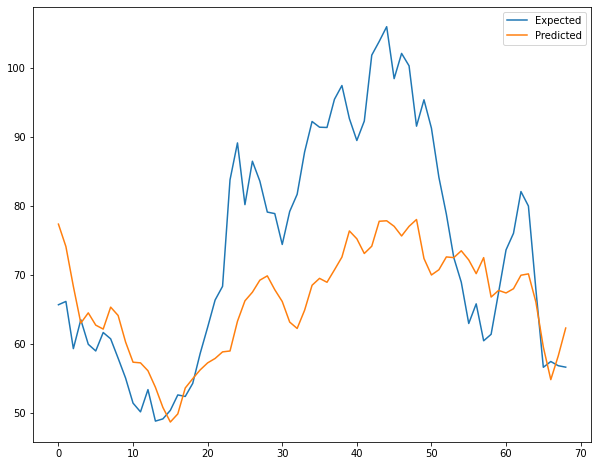

In [36]:
# plotting expected v/s predicted
plt.plot(inv_y, label='Expected')
plt.plot(inv_yhat, label='Predicted')
plt.legend()
plt.show()

## Using Talos for Hyperparameter tuning

In [40]:
# make function to use in talos
def lstm_model(train_X, train_y, val_X, val_y, params ):
    model = Sequential()
    model.add(LSTM(params['layer1_size'], input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences = True))
    model.add(layers.Activation(activations.relu))
    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['layer2_size'], return_sequences = False))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=params['optimizer'], metrics=['mae'])
    es = EarlyStopping(monitor='val_loss', patience=2, mode='min')
    # fit network
    out = model.fit(train_X, train_y, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2, verbose=2, shuffle=False, callbacks=[es])
    # plot history
    return out, model
    

#### Creating params grid for hyperparameters

In [43]:
p = {
     'optimizer': ['AdaDelta', 'adam'],
     'layer1_size': [32, 64, 128, 256],
     'layer2_size': [64,128],
     'batch_size': [32,64],
     'dropout':[0, 0.1,0.15],
     'epochs': [50,100,150,200]}

In [44]:
scan_object = talos.Scan(x=train_X,
                         y=train_y,
                         params=p,
                         model=lstm_model, experiment_name = 'talos1')

In [ ]:
# checking result of all iterations we ran for combinations
scan_object.data

start              end  ...  layer2_size  optimizer
0    05/30/21-145649  05/30/21-145656  ...           64   AdaDelta
1    05/30/21-145656  05/30/21-145704  ...           64       adam
2    05/30/21-145704  05/30/21-145711  ...          128   AdaDelta
3    05/30/21-145711  05/30/21-145715  ...          128       adam
4    05/30/21-145716  05/30/21-145722  ...           64   AdaDelta
..               ...              ...  ...          ...        ...
379  05/30/21-155358  05/30/21-155404  ...          128       adam
380  05/30/21-155405  05/30/21-155419  ...           64   AdaDelta
381  05/30/21-155420  05/30/21-155426  ...           64       adam
382  05/30/21-155427  05/30/21-155442  ...          128   AdaDelta
383  05/30/21-155442  05/30/21-155449  ...          128       adam

[384 rows x 14 columns]

In [46]:
# selecting best model from all model combinations run
best_model = scan_object.best_model(metric='val_mae', asc=True)

start              end  ...  layer2_size  optimizer
63  05/30/21-150650  05/30/21-150702  ...          128       adam
45  05/30/21-150258  05/30/21-150311  ...           64       adam
59  05/30/21-150557  05/30/21-150613  ...          128       adam
47  05/30/21-150325  05/30/21-150334  ...          128       adam
39  05/30/21-150159  05/30/21-150211  ...          128       adam

[5 rows x 14 columns]

In [50]:
# summary of the best model
best_model.summary()

In [55]:
# # saving best model and model weights
# best_model.save('timseries_with_dropout.h5')  
# best_model.save_weights('timseries_withdropout_weights.h5')

# loading best model and its weights
model = load_model('timseroes_withoutdropout.h5')
model.load_weights('timseroes_withoutdropout_weights.h5') 

### Making predictions with the best model on the original test data

In [ ]:
# predictions on test data
yhat_best = best_model.predict(test_X)
test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat_best, test_X_reshape[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y_reshape = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_reshape, test_X_reshape[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

### Checking best model performance

In [51]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [52]:
# calculate R2 score
print("R^2 score =", round(sm.r2_score(inv_y, inv_yhat), 2))

## Plotting original v/s predicted data from the best model